# Setups

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import seaborn as sns, numpy as np, pandas as pd
import pickle, logomaker
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from scipy.stats import entropy
from pymoo.indicators.hv import HV

import Bio, Bio.Align, Bio.SeqIO

from sklearn.manifold import SpectralEmbedding

from Bio import SeqIO

In [3]:
np.random.seed(1) # set random seed for scipy

In [4]:
bright_colors= sns.color_palette('bright')

In [5]:
cb_colors= np.array([
    [221, 221, 221],
    [46, 37, 133],
    [51, 117, 56],
    [93, 168, 153],
    [148, 203, 236],
    [220, 205, 125],
    [194, 106, 119],
    [159, 74, 150],
    [126, 41, 84]
])/255

In [6]:
def hex_to_rgb(value: str) -> list:
    value = value.lstrip('#')
    lv = len(value)
    return list(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))

In [7]:
def hex_interpolate(init, fin, scale: float) -> str:
    if isinstance(init, str):
        init_rgb= np.array(hex_to_rgb(init))
    else:
        init_rgb= 255*np.asarray(init)
    if isinstance(fin, str):
        fin_rgb= np.array(hex_to_rgb(fin))
    else:
        fin_rgb= 255*np.asarray(fin)
    
    color_rgb= (init_rgb + scale*(fin_rgb - init_rgb))/255.
    
    return tuple(color_rgb)

In [8]:
sns.set(font_scale= 1., font= 'Arial')
sns.set_style('ticks')

In [9]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

In [10]:
blosum62= Bio.Align.substitution_matrices.load('BLOSUM62')
aligner= Bio.Align.PairwiseAligner()
aligner.substitution_matrix= blosum62

# Process benchmark data

Read in collated benchmark data

In [101]:
RfaH_data= pd.read_parquet('data/benchmark_collated.gz.parquet')

Split data and compute summary statistics

In [13]:
n_generation= 50

af2rank_HV_ref_pt= np.array([0., 0.])
af2rank_hv_operator= HV(ref_point= af2rank_HV_ref_pt)

protein_mpnn_HV_ref_pt= np.array([4, 4])
protein_mpnn_hv_operator= HV(ref_point= protein_mpnn_HV_ref_pt)

In [14]:
# WT data
wt_data= RfaH_data[RfaH_data['method'] == 'WT'].squeeze()

wt_dict= {
    'identity': 1.0,
    'esm': -wt_data['neg_esm1v_chain_A'],
    'hv_protein_mpnn': (4 - wt_data['protein_mpnn_neg_log_prob_all_positions_chain_A'])*(4 - wt_data['protein_mpnn_neg_log_prob_all_positions_chain_B']),
    'hv_af2rank': wt_data['neg_af2rank_composite_chain_A_model_1_ptm']*wt_data['neg_af2rank_composite_chain_B_model_1_ptm']
}

In [15]:
# GA mutation operator & mutation rate benchmark data
df_GA_dict= {}
for GA_idx in range(1, 57):
    df_list= []
    af2rank_hv_list= []
    protein_mpnn_hv_list= []
    ave_identity_list= []
    ave_esm_list= []
    for itr in range(n_generation):
        df= RfaH_data.query(f'GA_idx == {GA_idx} & iteration == {itr}')

        af2rank_hv= af2rank_hv_operator(df[['neg_af2rank_composite_chain_A_model_1_ptm', 'neg_af2rank_composite_chain_B_model_1_ptm']].values)
        protein_mpnn_hv= protein_mpnn_hv_operator(df[['protein_mpnn_neg_log_prob_all_positions_chain_A', 'protein_mpnn_neg_log_prob_all_positions_chain_B']].values)
        ave_identity= np.mean(df['identity'])

        ave_esm= -np.mean(df['neg_esm1v_chain_A'])
        ave_esm_list.append(ave_esm)

        df_list.append(df)
        af2rank_hv_list.append(af2rank_hv)
        protein_mpnn_hv_list.append(protein_mpnn_hv)
        ave_identity_list.append(ave_identity)

    df_GA_dict[GA_idx]= {'df': df_list, 'hv_af2rank': af2rank_hv_list, 'hv_protein_mpnn': protein_mpnn_hv_list, 'identity': ave_identity_list, 'esm': ave_esm_list}

In [71]:
# GA reproducibility data
df_GA_repro_dict= {}
repro_idx= [36, 38, 40, 42]
mu_list= [0.1, 0.3, 0.5, 1.0]

df_GA_repro_dict['seed1']= {k: df_GA_dict[k] for k in repro_idx}
df_GA_repro_dict['seed2']= {}

for GA_idx, mu in zip(repro_idx, mu_list):
    df_list= []
    af2rank_hv_list= []
    protein_mpnn_hv_list= []
    ave_identity_list= []
    ave_esm_list= []
    for itr in range(n_generation):
        df_ref= df_GA_repro_dict['seed1'][GA_idx]['df'][0].iloc[0]
        df= RfaH_data.query(f'crossover == "{df_ref.crossover}" & position == "{df_ref.position}" & mutation == "{df_ref.mutation}" & objective == "{df_ref.objective}" & mu == {df_ref.mu} & iteration == {itr}')
        df= df[df["GA_idx"].isna()]

        af2rank_hv= af2rank_hv_operator(df[['neg_af2rank_composite_chain_A_model_1_ptm', 'neg_af2rank_composite_chain_B_model_1_ptm']].values)
        protein_mpnn_hv= protein_mpnn_hv_operator(df[['protein_mpnn_neg_log_prob_all_positions_chain_A', 'protein_mpnn_neg_log_prob_all_positions_chain_B']].values)
        ave_identity= np.mean(df['identity'])

        ave_esm= -np.mean(df['neg_esm1v_chain_A'])
        ave_esm_list.append(ave_esm)

        df_list.append(df)
        af2rank_hv_list.append(af2rank_hv)
        protein_mpnn_hv_list.append(protein_mpnn_hv)
        ave_identity_list.append(ave_identity)

    df_GA_repro_dict['seed2'][GA_idx]= {'df': df_list, 'hv_af2rank': af2rank_hv_list, 'hv_protein_mpnn': protein_mpnn_hv_list, 'identity': ave_identity_list, 'esm': ave_esm_list}

In [17]:
# GA n-point crossover benchmark data
df_GA_crossover_dict= {}

for idx, n_point in enumerate([1, 2, 3, 4, 'uniform']):
    df_list= []
    af2rank_hv_list= []
    protein_mpnn_hv_list= []
    ave_identity_list= []
    ave_esm_list= []
    for itr in range(n_generation):
        df= RfaH_data.query(f'crossover == "{n_point}" & position == "likelihood_ESM" & mutation == "ProteinMPNN-AD" & objective == "af2rank" & mu == 0.3 & iteration == {itr}')
        if n_point == 2:
            # filter out data generated using a different random seed
            df= df[~df['GA_idx'].isna()]
        af2rank_hv= af2rank_hv_operator(df[['neg_af2rank_composite_chain_A_model_1_ptm', 'neg_af2rank_composite_chain_B_model_1_ptm']].values)
        protein_mpnn_hv= protein_mpnn_hv_operator(df[['protein_mpnn_neg_log_prob_all_positions_chain_A', 'protein_mpnn_neg_log_prob_all_positions_chain_B']].values)
        ave_identity= np.mean(df['identity'])

        ave_esm= -np.mean(df['neg_esm1v_chain_A'])
        ave_esm_list.append(ave_esm)

        df_list.append(df)
        af2rank_hv_list.append(af2rank_hv)
        protein_mpnn_hv_list.append(protein_mpnn_hv)
        ave_identity_list.append(ave_identity)

    df_GA_crossover_dict[n_point]= {'df': df_list, 'hv_af2rank': af2rank_hv_list, 'hv_protein_mpnn': protein_mpnn_hv_list, 'identity': ave_identity_list, 'esm': ave_esm_list}

In [18]:
# ProteinMPNN-AD multistate design data
df_AD_dict= {}

df= RfaH_data.query('method == "AD" & temp == 0.3')

af2rank_hv= af2rank_hv_operator(df[['neg_af2rank_composite_chain_A_model_1_ptm', 'neg_af2rank_composite_chain_B_model_1_ptm']].values)
protein_mpnn_hv= protein_mpnn_hv_operator(df[['protein_mpnn_neg_log_prob_all_positions_chain_A', 'protein_mpnn_neg_log_prob_all_positions_chain_B']].values)
ave_identity= np.mean(df['identity'])

ave_esm= -np.mean(df['neg_esm1v_chain_A'])

df_AD_dict= {'df': df, 'hv_af2rank': af2rank_hv, 'hv_protein_mpnn': protein_mpnn_hv, 'identity': ave_identity, 'esm': ave_esm}

In [19]:
# ProteinMPNN-AD multistate design low temperature (0.1) data
df_AD_low_temp_dict= {}

df= RfaH_data.query('method == "AD" & temp == 0.1')

af2rank_hv= af2rank_hv_operator(df[['neg_af2rank_composite_chain_A_model_1_ptm', 'neg_af2rank_composite_chain_B_model_1_ptm']].values)
protein_mpnn_hv= protein_mpnn_hv_operator(df[['protein_mpnn_neg_log_prob_all_positions_chain_A', 'protein_mpnn_neg_log_prob_all_positions_chain_B']].values)
ave_identity= np.mean(df['identity'])

ave_esm= -np.mean(df['neg_esm1v_chain_A'])

df_AD_low_temp_dict= {'df': df, 'hv_af2rank': af2rank_hv, 'hv_protein_mpnn': protein_mpnn_hv, 'identity': ave_identity, 'esm': ave_esm}

In [20]:
# ProteinMPNN-SD single-state design data
df_ss_dict= {}

for chain in ['A', 'B']:
    df= RfaH_data[RfaH_data['method'] == f'SD_{chain}']

    af2rank_hv= af2rank_hv_operator(df[['neg_af2rank_composite_chain_A_model_1_ptm', 'neg_af2rank_composite_chain_B_model_1_ptm']].values)
    protein_mpnn_hv= protein_mpnn_hv_operator(df[['protein_mpnn_neg_log_prob_all_positions_chain_A', 'protein_mpnn_neg_log_prob_all_positions_chain_B']].values)
    ave_identity= np.mean(df['identity'])

    if chain == 'A':
        ave_esm= -np.mean(df['neg_esm1v_chain_A'])
    else:
        ave_esm= -np.mean(df['neg_esm1v_chain_B'])

    df_ss_dict[chain]= {'df': df, 'hv_af2rank': af2rank_hv, 'hv_protein_mpnn': protein_mpnn_hv, 'identity': ave_identity, 'esm': ave_esm}

# Data Visualization

Random resetting operator sequence entropy

/tmp/ipykernel_81429/195610553.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(list(wt_data['candidate']))


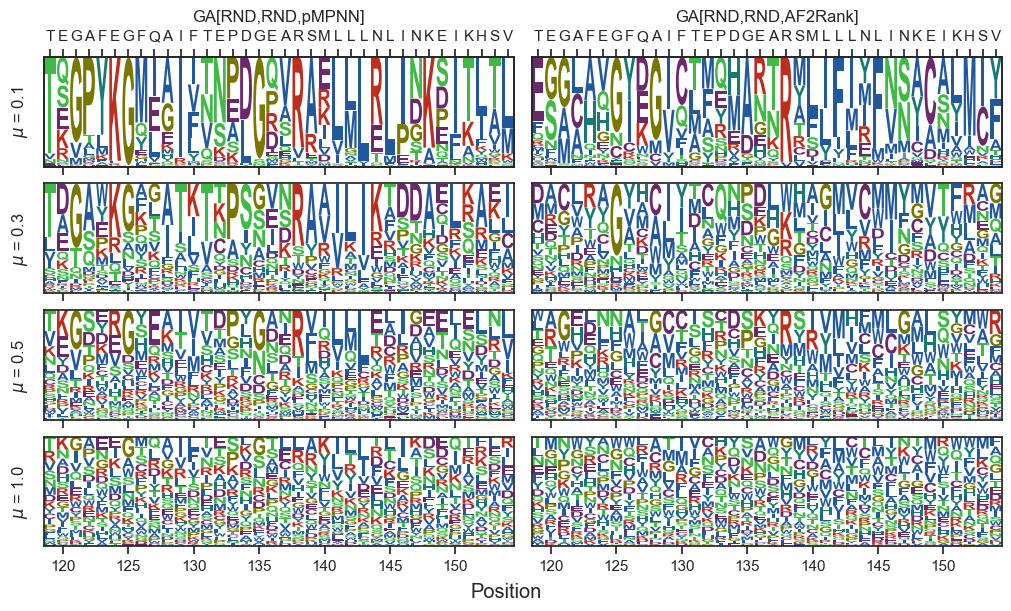

In [21]:
random_resetting_pmpnn= [1, 3, 5, 7]
random_resetting_af2rank= [8, 10, 12, 14]
random_resetting_mu= [0.1, 0.3, 0.5, 1.0]

all_resids= np.array(list(range(119, 155)))
all_resids_idx= pd.Index(all_resids, name= 'pos')

msa_dict= {}
for idx in random_resetting_pmpnn + random_resetting_af2rank:
    msa= logomaker.alignment_to_matrix(
        df_GA_dict[idx]['df'][-1]['candidate'].values,
        to_type= 'counts'
    )
    msa.index= all_resids_idx
    msa_dict[idx]= msa

fig, axes= plt.subplots(4, 2, figsize= (10, 6), sharex= True, sharey= True, layout= 'constrained')

for idx, (idx_pmpnn, idx_af2rank) in enumerate(zip(random_resetting_pmpnn, random_resetting_af2rank)):
    logo_pmpnn= logomaker.Logo(msa_dict[idx_pmpnn], ax= axes[idx, 0], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    logo_af2rank= logomaker.Logo(msa_dict[idx_af2rank], ax= axes[idx, 1], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

    logo_pmpnn.ax.set(
        yticks= [],
        ylabel= f'$\mu$ = {random_resetting_mu[idx]}'
    )

    if idx == 0:
        for ax2 in [logo_pmpnn.ax.twiny(), logo_af2rank.ax.twiny()]:
            ax2.set_xlim(logo_pmpnn.ax.get_xlim())
            ax2.set_xticklabels(list(wt_data['candidate']))
            ax2.set_xticks(all_resids)
        logo_pmpnn.ax.set(
            title= 'GA[RND,RND,pMPNN]'
        )
        logo_af2rank.ax.set(
            title= 'GA[RND,RND,AF2Rank]'
        )

fig.supxlabel('Position')

plt.show()

#fig.savefig('./random_resetting_logo.png', bbox_inches='tight', dpi= 600)

GA mutation operator & mutation rate benchmark summary plot

In [22]:
mutation_rates= np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0])

batch_settings_dict_formatted= {}
batch_settings_ind= 1
for choose_pos_method, choose_AA_method, objective_type in zip(*[
    ['RND',  'RND', 'RND',   'RND',   'ESM',   'ESM',   'RND',       'RND'],
    ['RND',  'RND', 'pMPNN', 'pMPNN', 'pMPNN', 'pMPNN', 'pMPNN',     'pMPNN'],
    ['pMPNN', 'AF', 'pMPNN', 'AF',   'pMPNN',  'AF',    'pMPNN+ESM', 'AF+ESM']
]):
    for mutation_rate in mutation_rates:
            batch_settings_dict_formatted[batch_settings_ind]= {}
            batch_settings_dict_formatted[batch_settings_ind]['choose_pos_method']= choose_pos_method
            batch_settings_dict_formatted[batch_settings_ind]['choose_AA_method']= choose_AA_method
            batch_settings_dict_formatted[batch_settings_ind]['objective_type']= objective_type
            batch_settings_dict_formatted[batch_settings_ind]['mutation_rate']= mutation_rate
            batch_settings_ind+= 1

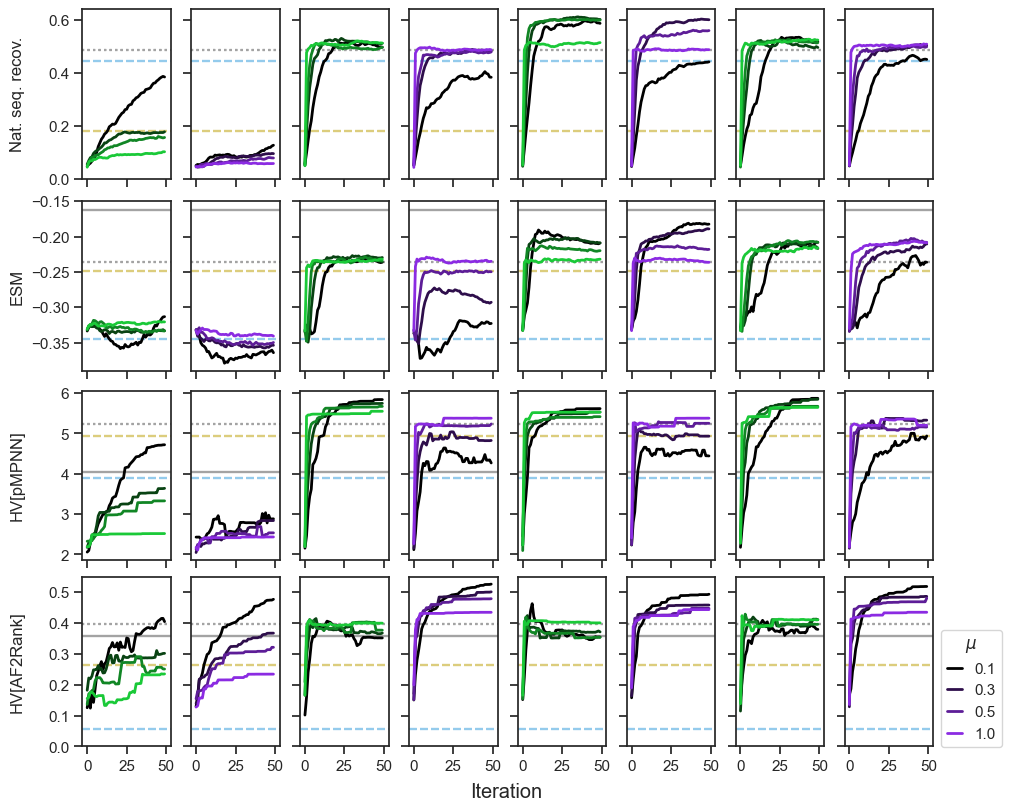

In [23]:
fig, axes= plt.subplots(4, 8, figsize= (10, 8), sharex= True, sharey= 'row', layout= 'constrained')

mu_idx= [0, 2, 4, 6] # only show results for mutation rates 0.1, 0.3, 0.5, and 1.0

color_idx= 0
for metric_idx, metric in enumerate(['identity', 'esm', 'hv_protein_mpnn', 'hv_af2rank']):
    for (idx, data_dict), settings in zip(df_GA_dict.items(), batch_settings_dict_formatted.values()):
        if int((idx - 1)%7) not in mu_idx:
            pass
        else:
            ax= axes[metric_idx, int((idx-1)/7)]

            ax.axhline(df_AD_dict[metric], color= bright_colors[-3], linestyle= 'dotted', zorder= 0)
            if metric_idx != 0:
                ax.axhline(wt_dict[metric], color= bright_colors[-3], linestyle= 'solid', zorder= 0)
            ax.axhline(df_ss_dict['A'][metric], color= cb_colors[4], linestyle= 'dashed', zorder= 0)
            ax.axhline(df_ss_dict['B'][metric], color= cb_colors[5], linestyle= 'dashed', zorder= 0)

            y_data= data_dict[metric]
            x_data= list(range(len(y_data)))
            sns.lineplot(
                x= x_data, y= y_data,
                linewidth= 2,
                color= hex_interpolate(
                    [0, 0, 0], 
                    bright_colors[2] if int(((idx - 1)/7)%2) == 0 else bright_colors[4], 
                    (color_idx%len(mu_idx))/(len(mu_idx) - 1)
                ),
                label= mutation_rates[int((idx - 1)%7)],
                ax= ax
            )
            color_idx+= 1

            ax.set(
                xlim= [-3, 53],
                xticks= [0, 25, 50]
            )
            if metric_idx == 0:
                ax.set(yticks= [0., 0.2, 0.4, 0.6])
            elif metric_idx == 1:
                ax.set(yticks= [-0.35, -0.3, -0.25, -0.2, -0.15])
            elif metric_idx == 3:
                ax.set(yticks= [0., 0.1, 0.2, 0.3, 0.4, 0.5])

            ax.get_legend().remove()

axes[0, 0].set(
    ylabel= 'Nat. seq. recov.'
)
axes[1, 0].set(
    ylabel= 'ESM'
)
axes[2, 0].set(
    ylabel= 'HV[pMPNN]'
)
axes[3, 0].set(
    ylabel= 'HV[AF2Rank]'
)


ax= axes[3, 7]
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(
    legend_handles, mutation_rates[mu_idx], title= r'$\mu$',
    bbox_to_anchor= (1, 0.73), loc= 'upper left',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

fig.align_labels()
fig.supxlabel('Iteration')

plt.show()

#fig.savefig('./RfaH_GA_benchmark_stats.svg', bbox_inches='tight', dpi= 600)

GA mutation operator & mutation rate benchmark summary plot (full)

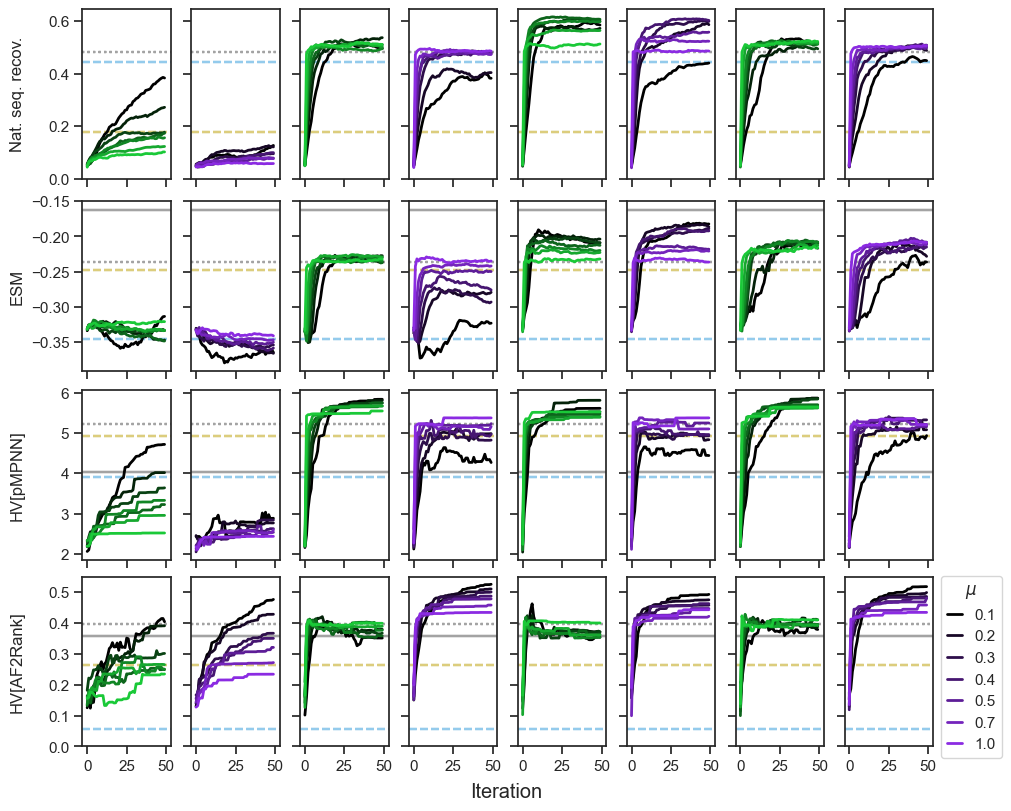

In [24]:
fig, axes= plt.subplots(4, 8, figsize= (10, 8), sharex= True, sharey= 'row', layout= 'constrained')

color_idx= 0
for metric_idx, metric in enumerate(['identity', 'esm', 'hv_protein_mpnn', 'hv_af2rank']):
    for (idx, data_dict), settings in zip(df_GA_dict.items(), batch_settings_dict_formatted.values()):
        ax= axes[metric_idx, int((idx-1)/7)]

        ax.axhline(df_AD_dict[metric], color= bright_colors[-3], linestyle= 'dotted', zorder= 0)
        if metric_idx != 0:
            ax.axhline(wt_dict[metric], color= bright_colors[-3], linestyle= 'solid', zorder= 0)
        ax.axhline(df_ss_dict['A'][metric], color= cb_colors[4], linestyle= 'dashed', zorder= 0)
        ax.axhline(df_ss_dict['B'][metric], color= cb_colors[5], linestyle= 'dashed', zorder= 0)

        y_data= data_dict[metric]
        x_data= list(range(len(y_data)))
        sns.lineplot(
            x= x_data, y= y_data,
            linewidth= 2,
            color= hex_interpolate(
                [0, 0, 0], 
                bright_colors[2] if int(((idx - 1)/7)%2) == 0 else bright_colors[4], 
                (color_idx%len(mutation_rates))/(len(mutation_rates) - 1)
            ),
            label= mutation_rates[int((idx - 1)%7)],
            ax= ax
        )
        color_idx+= 1

        ax.set(
            xlim= [-3, 53],
            xticks= [0, 25, 50]
        )
        if metric_idx == 0:
            ax.set(yticks= [0., 0.2, 0.4, 0.6])
        elif metric_idx == 1:
            ax.set(yticks= [-0.35, -0.3, -0.25, -0.2, -0.15])
        elif metric_idx == 3:
            ax.set(yticks= [0., 0.1, 0.2, 0.3, 0.4, 0.5])

        ax.get_legend().remove()

axes[0, 0].set(
    ylabel= 'Nat. seq. recov.'
)
axes[1, 0].set(
    ylabel= 'ESM'
)
axes[2, 0].set(
    ylabel= 'HV[pMPNN]'
)
axes[3, 0].set(
    ylabel= 'HV[AF2Rank]'
)


ax= axes[3, 7]
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(
    legend_handles, mutation_rates, title= r'$\mu$',
    bbox_to_anchor= (1, 1.05), loc= 'upper left',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

fig.align_labels()
fig.supxlabel('Iteration')

plt.show()

#fig.savefig('./RfaH_GA_benchmark_stats_full.svg', bbox_inches='tight', dpi= 600)

Seq entropy summary plot

In [25]:
entropy_dict= {}
for idx, data_dict in df_GA_dict.items():
    msa= logomaker.alignment_to_matrix(data_dict['df'][-1]['candidate'], to_type= 'counts')

    ent= []
    for _, pos in msa.iterrows():
        ent.append(entropy(list(pos)))
    entropy_dict[idx]= ent

msa_AD= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'], to_type= 'counts')
entropy_AD= []
for idx, pos in msa_AD.iterrows():
    entropy_AD.append(entropy(list(pos)))

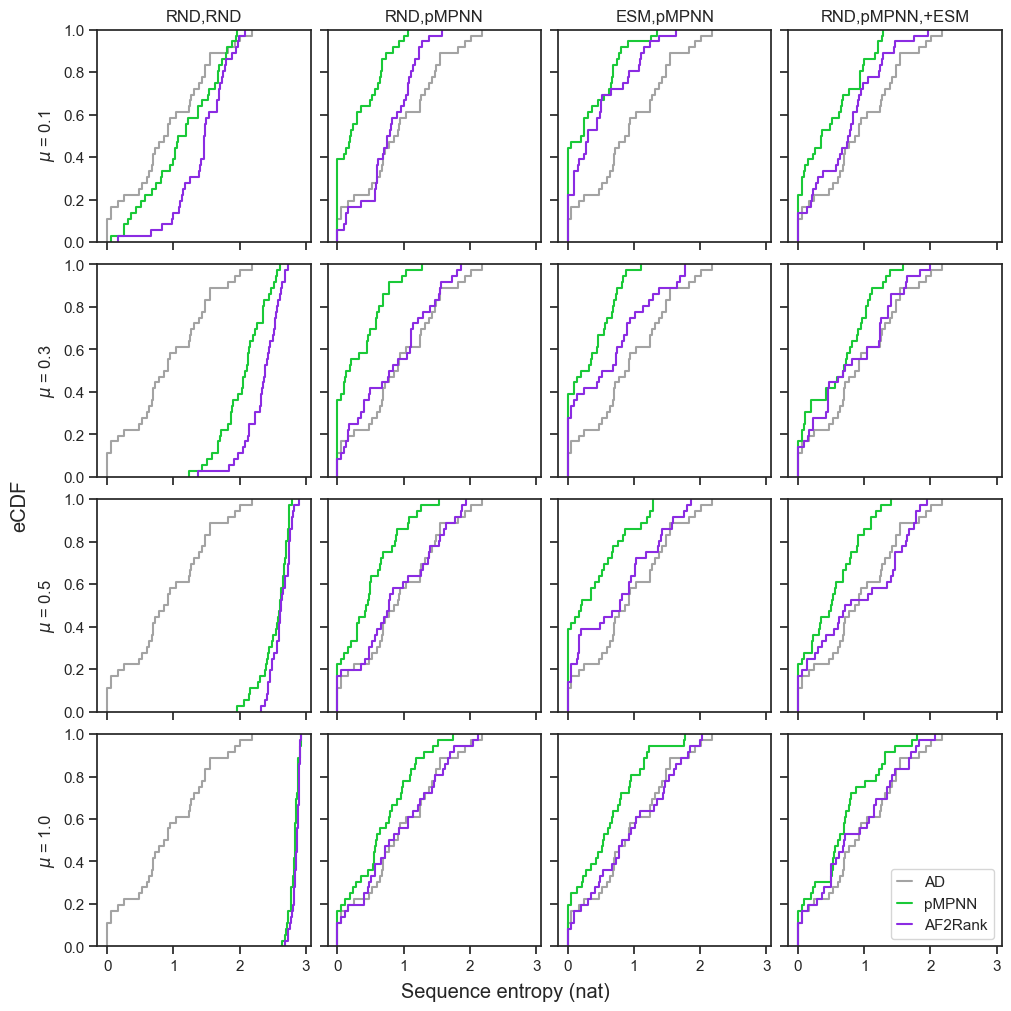

In [26]:
fig, axes= plt.subplots(4, 4, figsize= (10, 10), layout= 'constrained', sharex= True, sharey= True)

title_list= ['RND,RND', 'RND,pMPNN', 'ESM,pMPNN', 'RND,pMPNN,+ESM']
mu_idx= [0, 2, 4, 6] # only show results for mutation rates 0.1, 0.3, 0.5, and 1.0

i = 0
for ent_data, mu in zip(entropy_dict.values(), [0.1, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0]*8):
    if mu not in [0.1, 0.3, 0.5, 1.0]:
        pass
    else:
        ax= axes[int(i%4), int(i/8)]

        if int(i%8) < 4:
            sns.ecdfplot(x= entropy_AD, ax= ax, color= bright_colors[-3], label= 'AD')
        sns.ecdfplot(
            x= ent_data, 
            ax= ax, 
            color= bright_colors[2] if int(i%8) < 4 else bright_colors[4],
            label= 'pMPNN' if int(i%8) < 4 else 'AF2Rank'
            )

        if int(i/8) == 0:
            ax.set(ylabel= f'$\mu$ = {mu}')
        if int(i%4) == 0:
            ax.set(title= title_list[int(i/8)])
        
        i+= 1

fig.supxlabel('Sequence entropy (nat)')
fig.supylabel('eCDF')

legend_handles, _= axes[3, 3].get_legend_handles_labels()
axes[3, 3].legend(
    legend_handles, ['AD', 'pMPNN', 'AF2Rank'],
    loc= 'lower right',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

plt.show()

#fig.savefig('./seq_entropy_all_conditions.png', bbox_inches='tight', dpi= 600)

Nondominated sorting of AD sequences

In [27]:
# https://stackoverflow.com/questions/32791911/fast-calculation-of-pareto-front-in-python
def is_pareto_efficient(costs, return_mask = True):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :param return_mask: True to return a mask
    :return: An array of indices of pareto-efficient points.
        If return_mask is True, this will be an (n_points, ) boolean array
        Otherwise it will be a (n_efficient_points, ) integer array of indices.
    """
    is_efficient = np.arange(costs.shape[0])
    n_points = costs.shape[0]
    next_point_index = 0  # Next index in the is_efficient array to search for
    while next_point_index<len(costs):
        nondominated_point_mask = np.any(costs<costs[next_point_index], axis=1)
        nondominated_point_mask[next_point_index] = True
        is_efficient = is_efficient[nondominated_point_mask]  # Remove dominated points
        costs = costs[nondominated_point_mask]
        next_point_index = np.sum(nondominated_point_mask[:next_point_index])+1
    if return_mask:
        is_efficient_mask = np.zeros(n_points, dtype = bool)
        is_efficient_mask[is_efficient] = True
        return is_efficient_mask
    else:
        return is_efficient

In [28]:
is_af2rank_pareto_optimal= is_pareto_efficient(df_AD_dict['df'][['neg_af2rank_composite_chain_A_model_1_ptm', 'neg_af2rank_composite_chain_B_model_1_ptm']].values)
is_pmpnn_pareto_optimal= is_pareto_efficient(df_AD_dict['df'][['protein_mpnn_neg_log_prob_all_positions_chain_A', 'protein_mpnn_neg_log_prob_all_positions_chain_B']].values)

In [29]:
msa_ad= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'], to_type= 'counts')
msa_af2rank_pareto= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'][is_af2rank_pareto_optimal], to_type= 'counts')
msa_pmpnn_pareto= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'][is_pmpnn_pareto_optimal], to_type= 'counts')

In [30]:
entropy_pmpnn_pareto= []
for idx, pos in msa_pmpnn_pareto.iterrows():
    entropy_pmpnn_pareto.append(entropy(list(pos)))

entropy_pmpnn_random= []
for _ in range(100):
    msa_ad= logomaker.alignment_to_matrix(np.random.choice(df_AD_dict['df']['candidate'].values, size= sum(is_pmpnn_pareto_optimal)), to_type= 'counts')
    for idx, pos in msa_ad.iterrows():
        entropy_pmpnn_random.append(entropy(list(pos)))

ga_1_idx= 31
entropy_GA1_random= []
for _ in range(100):
    msa_GA1= logomaker.alignment_to_matrix(np.random.choice(df_GA_dict[ga_1_idx]['df'][-1]['candidate'].values, size= sum(is_pmpnn_pareto_optimal)), to_type= 'counts')

    for idx, pos in msa_GA1.iterrows():
        entropy_GA1_random.append(entropy(list(pos)))

In [31]:
entropy_af2rank_pareto= []
for idx, pos in msa_af2rank_pareto.iterrows():
    entropy_af2rank_pareto.append(entropy(list(pos)))

entropy_af2rank_random= []
for _ in range(100):
    msa_ad= logomaker.alignment_to_matrix(np.random.choice(df_AD_dict['df']['candidate'].values, size= sum(is_af2rank_pareto_optimal)), to_type= 'counts')
    for idx, pos in msa_ad.iterrows():
        entropy_af2rank_random.append(entropy(list(pos)))

ga_2_idx= ga_1_idx + 7
entropy_GA2_random= []
for _ in range(100):
    msa_GA2= logomaker.alignment_to_matrix(np.random.choice(df_GA_dict[ga_2_idx]['df'][-1]['candidate'].values, size= sum(is_af2rank_pareto_optimal)), to_type= 'counts')

    for idx, pos in msa_GA2.iterrows():
        entropy_GA2_random.append(entropy(list(pos)))

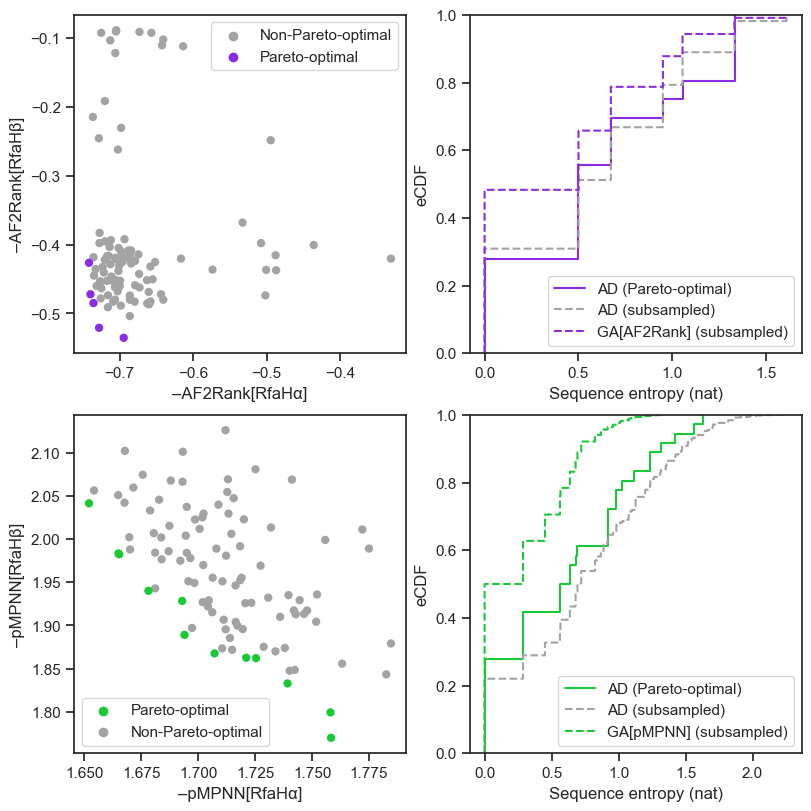

In [32]:
fig, axes= plt.subplots(2, 2, figsize= (8, 8), layout= 'constrained')

sns.scatterplot(
    data= df_AD_dict['df'],
    x= 'neg_af2rank_composite_chain_A_model_1_ptm',
    y= 'neg_af2rank_composite_chain_B_model_1_ptm',
    hue= ['Pareto-optimal' if opt == True else 'Non-Pareto-optimal' for opt in is_af2rank_pareto_optimal],
    palette= {'Pareto-optimal': bright_colors[4], 'Non-Pareto-optimal': bright_colors[-3]},
    linewidth= 0,
    ax= axes[0, 0]
)

sns.scatterplot(
    data= df_AD_dict['df'],
    x= 'protein_mpnn_neg_log_prob_all_positions_chain_A',
    y= 'protein_mpnn_neg_log_prob_all_positions_chain_B',
    hue= ['Pareto-optimal' if opt == True else 'Non-Pareto-optimal' for opt in is_pmpnn_pareto_optimal],
    palette= {'Pareto-optimal': bright_colors[2], 'Non-Pareto-optimal': bright_colors[-3]},
    linewidth= 0,
    ax= axes[1, 0]
)

sns.ecdfplot(entropy_af2rank_pareto, ax= axes[0, 1], color= bright_colors[4], label= 'AD (Pareto-optimal)')
sns.ecdfplot(entropy_af2rank_random, ax= axes[0, 1], color= bright_colors[-3], linestyle= 'dashed', label= 'AD (subsampled)')
sns.ecdfplot(entropy_GA2_random, ax= axes[0, 1], color= bright_colors[4], linestyle= 'dashed', label= 'GA[AF2Rank] (subsampled)')
axes[0, 1].legend()

sns.ecdfplot(entropy_pmpnn_pareto, ax= axes[1, 1], color= bright_colors[2], label= 'AD (Pareto-optimal)')
sns.ecdfplot(entropy_pmpnn_random, ax= axes[1, 1], color= bright_colors[-3], linestyle= 'dashed', label= 'AD (subsampled)')
sns.ecdfplot(entropy_GA1_random, ax= axes[1, 1], color= bright_colors[2], linestyle= 'dashed', label= 'GA[pMPNN] (subsampled)')
axes[1, 1].legend()

axes[0, 0].set(
    xlabel= '–AF2Rank[RfaHα]', ylabel= '–AF2Rank[RfaHβ]'
)
axes[1, 0].set(
    xlabel= '–pMPNN[RfaHα]', ylabel= '–pMPNN[RfaHβ]'
)

axes[0, 1].set(xlabel= 'Sequence entropy (nat)', ylabel= 'eCDF')
axes[1, 1].set(xlabel= 'Sequence entropy (nat)', ylabel= 'eCDF')

plt.show()

#fig.savefig('./post_hoc_filtering_seq_entropy.png', bbox_inches='tight', dpi= 600)

GA n-point crossover benchmark

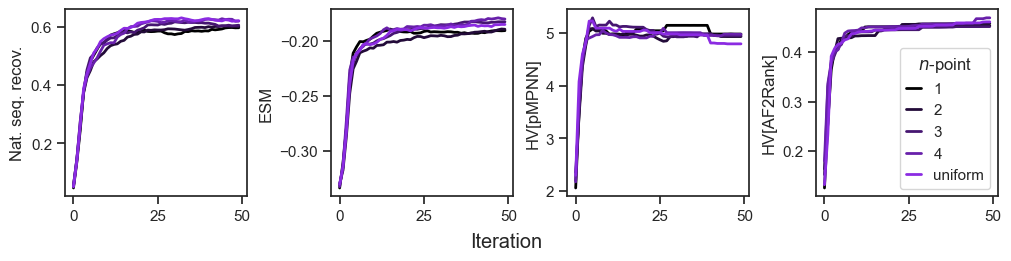

In [33]:
fig, axes= plt.subplots(1, 4, figsize= (10, 2.5), layout= 'constrained', sharex= True)

n_point_list= [1, 2, 3, 4, 'uniform']

for metric_idx, metric in enumerate(['identity', 'esm', 'hv_protein_mpnn', 'hv_af2rank']):
    ax= axes[metric_idx]
    for idx, n_point in enumerate(n_point_list):
        y_data= df_GA_crossover_dict[n_point][metric]
        x_data= list(range(len(y_data)))

        sns.lineplot(
            x= x_data, y= y_data,
            linewidth= 2,
            color= hex_interpolate(
                [0, 0, 0], 
                bright_colors[4], 
                idx/4
            ),
            label= n_point,
            ax= ax
        )

        ax.set(xticks= [0, 25, 50])

        ax.get_legend().remove()

axes[0].set(
    ylabel= 'Nat. seq. recov.'
)
axes[1].set(
    ylabel= 'ESM'
)
axes[2].set(
    ylabel= 'HV[pMPNN]'
)
axes[3].set(
    ylabel= 'HV[AF2Rank]'
)

fig.supxlabel('Iteration')

legend_handles, _= axes[-1].get_legend_handles_labels()
axes[-1].legend(
    legend_handles, n_point_list, title= '$n$-point', 
    loc= 'lower right',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

plt.show()

#fig.savefig('./crossover_benchmark.png', bbox_inches='tight', dpi= 600)

GA[RND,pMPNN,pMPNN] objective space separation plot

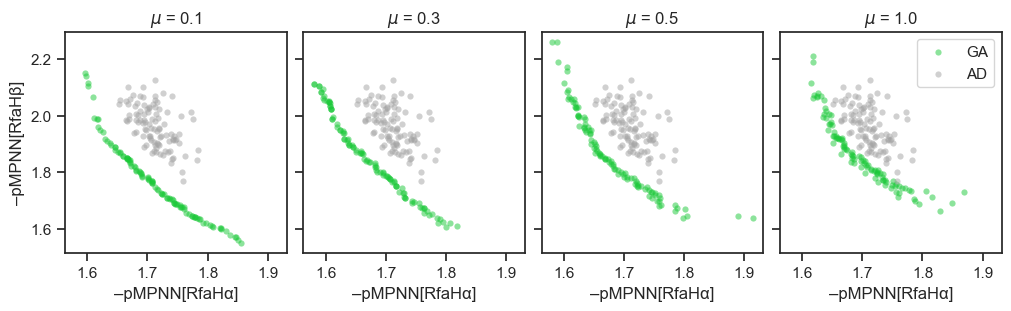

In [34]:
pmpnn_idx_list= [15, 17, 19, 21]
mutation_rate_list= [0.1, 0.3, 0.5, 1.0]

alpha= 0.5
s= 20

fig, axes= plt.subplots(1, 4, figsize= (10, 3), sharex= True, sharey= True, layout= 'constrained')

for idx, pmpnn_idx in enumerate(pmpnn_idx_list):
    ax= axes[idx]

    sns.scatterplot(
        data= df_GA_dict[pmpnn_idx]['df'][-1],
        x= 'protein_mpnn_neg_log_prob_all_positions_chain_A',
        y= 'protein_mpnn_neg_log_prob_all_positions_chain_B',
        label= 'GA',
        ax= ax,
        color= bright_colors[2],
        alpha= alpha,
        s= s,
        linewidth= 0
    )

    sns.scatterplot(
        data= df_AD_dict['df'], 
        x= 'protein_mpnn_neg_log_prob_all_positions_chain_A', 
        y= 'protein_mpnn_neg_log_prob_all_positions_chain_B',
        label= 'AD',
        ax= ax,
        color= bright_colors[-3],
        alpha= alpha, 
        s= s, 
        linewidth= 0
    )

    ax.set(
        xlabel= '–pMPNN[RfaHα]', ylabel= '–pMPNN[RfaHβ]',
        title= f'$\mu$ = {mutation_rate_list[idx]}'
    )

    if idx != 3:
        ax.get_legend().remove()

plt.show()

#fig.savefig('./ga_pmpnn_vs_ad.png', bbox_inches='tight', dpi= 600)

Effect of using ESM-1v as a third objective function

In [35]:
candidates= []
identities= []
methods= []
esm_scores= []

for idx in [31, 38, 45, 52]:
    new_candidates= list(df_GA_dict[idx]['df'][-1]['candidate'].values)
    methods+= [f'GA_{idx}']*len(new_candidates)
    candidates+= new_candidates
    identities+= list(df_GA_dict[idx]['df'][-1]['identity'].values)
    esm_scores+= list(-df_GA_dict[idx]['df'][-1]['neg_esm1v_chain_A'].values)

new_candidates= list(df_AD_dict['df']['candidate'].values)
methods+= ['AD']*len(new_candidates)
candidates+= new_candidates
identities+= list(df_AD_dict['df']['identity'].values)
esm_scores+= list(-df_AD_dict['df']['neg_esm1v_chain_A'].values)

new_candidates= list(df_ss_dict['A']['df']['candidate'].values)
methods+= ['ss_A']*len(new_candidates)
candidates+= new_candidates
identities+= list(df_ss_dict['A']['df']['identity'].values)
esm_scores+= list(-df_ss_dict['A']['df']['neg_esm1v_chain_A'].values)

new_candidates= list(df_ss_dict['B']['df']['candidate'].values)
methods+= ['ss_B']*len(new_candidates)
candidates+= new_candidates
identities+= list(df_ss_dict['B']['df']['identity'].values)
esm_scores+= list(-df_ss_dict['B']['df']['neg_esm1v_chain_B'].values)

candidates+= [wt_data['candidate']]
methods+= ['WT']
identities+= [1.0]
esm_scores+= [-wt_data['neg_esm1v_chain_A']]

candidates_df= pd.DataFrame({'candidate': candidates, 'identity': identities, 'esm': esm_scores, 'method': methods})

blosum_matrix= []
for candidate_1, method_1 in zip(candidates_df['candidate'], candidates_df['method']):
    blosum_dists= []
    for candidate_2, method_2 in zip(candidates_df['candidate'], candidates_df['method']):
        blosum_dist= aligner.align(str(candidate_1), str(candidate_2)).score/len(candidate_1)
        blosum_dists.append(blosum_dist)
    blosum_matrix.append(blosum_dists)
blosum_matrix= np.asarray(blosum_matrix)

embedding = SpectralEmbedding(n_components=2, affinity= 'precomputed')
blosum_matrix_transformed = embedding.fit_transform(blosum_matrix)

embedding_esm_df= pd.DataFrame({'seq_embed_1': blosum_matrix_transformed[:, 0], 'seq_embed_2': blosum_matrix_transformed[:, 1], 'identity': candidates_df['identity'], 'esm': candidates_df['esm'], 'method': candidates_df['method']})

In [36]:
embedding_esm_df[(embedding_esm_df['method'] != 'WT') & (embedding_esm_df['method'] != 'AD')].describe()

,seq_embed_1,seq_embed_2,identity,esm
count,600.000000,600.000000,600.000000,600.000000
mean,0.000098,0.000058,0.470509,-0.236612
std,0.000963,0.000919,0.151979,0.058277
min,-0.000901,-0.001300,0.111111,-0.430259
25%,-0.000482,-0.000556,0.416667,-0.258337
50%,-0.000333,-0.000256,0.500000,-0.220392
75%,0.000090,0.000404,0.583333,-0.192343
max,0.002606,0.002794,0.722222,-0.156130


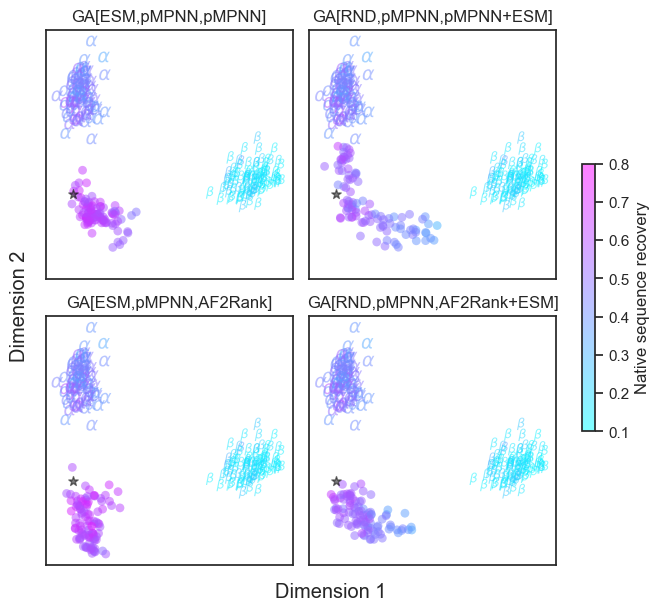

In [37]:
fig, axes= plt.subplots(2, 2, figsize= (6.5, 6), sharex= True, sharey= True, layout= 'constrained')

esm_idx_list= [31, 45, 38, 52]
esm_label_list= ['GA[ESM,pMPNN,pMPNN]', 'GA[RND,pMPNN,pMPNN+ESM]', 'GA[ESM,pMPNN,AF2Rank]', 'GA[RND,pMPNN,AF2Rank+ESM]']

for idx, (esm_idx, esm_label) in enumerate(zip(esm_idx_list, esm_label_list)):
    for method, m in zip([f'GA_{esm_idx}', 'ss_A', 'ss_B', 'WT'], ['o', r'$\alpha$', r'$\beta$', '*']):
        ax= axes[int(idx/2), int(idx%2)]
        df= embedding_esm_df[embedding_esm_df['method'] == method]
        if method != 'WT':
            scatter_plt= ax.scatter(
                df['seq_embed_1'],
                df['seq_embed_2'],
                c= df['identity'],
                marker= m,
                s= 40 if method == f'GA_{esm_idx}' else 80,
                vmin= 0.1,
                vmax= 0.8,
                cmap= 'cool',
                alpha= 0.5,
                edgecolor= 'none',
            )
        else:
            ax.scatter(
                df['seq_embed_1'],
                df['seq_embed_2'],
                c= 'black',
                marker= m,
                s= 50,
                alpha= 0.5
            )

        ax.set(
            xticks= [], yticks= [],
            title= esm_label
        )

fig.colorbar(scatter_plt, ax= axes.ravel().tolist(), label= 'Native sequence recovery', shrink= 0.5)

fig.supxlabel('Dimension 1')
fig.supylabel('Dimension 2')

plt.show()

#fig.savefig('./esm_as_objective.png', bbox_inches='tight', dpi= 600)

Sequence anlaysis plot

In [38]:
ga_1_idx= 31
ga_2_idx= ga_1_idx + 7

msa_GA1= logomaker.alignment_to_matrix(df_GA_dict[ga_1_idx]['df'][-1]['candidate'], to_type= 'counts')
msa_GA2= logomaker.alignment_to_matrix(df_GA_dict[ga_2_idx]['df'][-1]['candidate'], to_type= 'counts')
msa_AD= logomaker.alignment_to_matrix(df_AD_dict['df']['candidate'], to_type= 'counts')
msa_AD_low_temp= logomaker.alignment_to_matrix(df_AD_low_temp_dict['df']['candidate'], to_type= 'counts')
msa_ss_A= logomaker.alignment_to_matrix(df_ss_dict['A']['df']['candidate'], to_type= 'counts')
msa_ss_B= logomaker.alignment_to_matrix(df_ss_dict['B']['df']['candidate'], to_type= 'counts')

all_resids= np.array(list(range(119, 155)))
all_resids_idx= pd.Index(all_resids, name= 'pos')
msa_GA1.index= all_resids_idx
msa_GA2.index= all_resids_idx
msa_AD.index= all_resids_idx
msa_AD_low_temp.index= all_resids_idx
msa_ss_A.index= all_resids_idx
msa_ss_B.index= all_resids_idx


entropy_GA1= []
for idx, pos in msa_GA1.iterrows():
    entropy_GA1.append(entropy(list(pos)))

entropy_GA2= []
for idx, pos in msa_GA2.iterrows():
    entropy_GA2.append(entropy(list(pos)))

entropy_AD= []
for idx, pos in msa_AD.iterrows():
    entropy_AD.append(entropy(list(pos)))

entropy_AD_low_temp= []
for idx, pos in msa_AD_low_temp.iterrows():
    entropy_AD_low_temp.append(entropy(list(pos)))

entropy_ss_A= []
for idx, pos in msa_ss_A.iterrows():
    entropy_ss_A.append(entropy(list(pos)))

entropy_ss_B= []
for idx, pos in msa_ss_B.iterrows():
    entropy_ss_B.append(entropy(list(pos)))


candidates= []
methods= []

new_candidates= list(df_GA_dict[ga_1_idx]['df'][-1]['candidate'].values)
methods+= [f'GA_{ga_1_idx}']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_GA_dict[ga_2_idx]['df'][-1]['candidate'].values)
methods+= [f'GA_{ga_2_idx}']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_AD_dict['df']['candidate'].values)
methods+= ['AD']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_ss_dict['A']['df']['candidate'].values)
methods+= ['ss_A']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_ss_dict['B']['df']['candidate'].values)
methods+= ['ss_B']*len(new_candidates)
candidates+= new_candidates

candidates+= [wt_data['candidate']]
methods+= ['WT']

candidates_df= pd.DataFrame({'candidate': candidates, 'method': methods})

blosum_matrix= []
for candidate_1, method_1 in zip(candidates_df['candidate'], candidates_df['method']):
    blosum_dists= []
    for candidate_2, method_2 in zip(candidates_df['candidate'], candidates_df['method']):
        blosum_dist= aligner.align(str(candidate_1), str(candidate_2)).score/len(candidate_1)
        blosum_dists.append(blosum_dist)
    blosum_matrix.append(blosum_dists)
blosum_matrix= np.asarray(blosum_matrix)

embedding = SpectralEmbedding(n_components=2, affinity= 'precomputed')
blosum_matrix_transformed = embedding.fit_transform(blosum_matrix)

embedding_df= pd.DataFrame({'seq_embed_1': blosum_matrix_transformed[:, 0], 'seq_embed_2': blosum_matrix_transformed[:, 1], 'method': candidates_df['method']})

rsa_A= pd.read_csv('/home/lu/Dropbox/multistate_paper/getarea/getarea_5ond.csv')
rsa_B= pd.read_csv('/home/lu/Dropbox/multistate_paper/getarea/getarea_2lcl.csv')

rsa_A= rsa_A[(119 <= rsa_A['Resid']) & (rsa_A['Resid'] <= 154)].reset_index()
rsa_B= rsa_B[(119 <= rsa_B['Resid']) & (rsa_B['Resid'] <= 154)].reset_index()

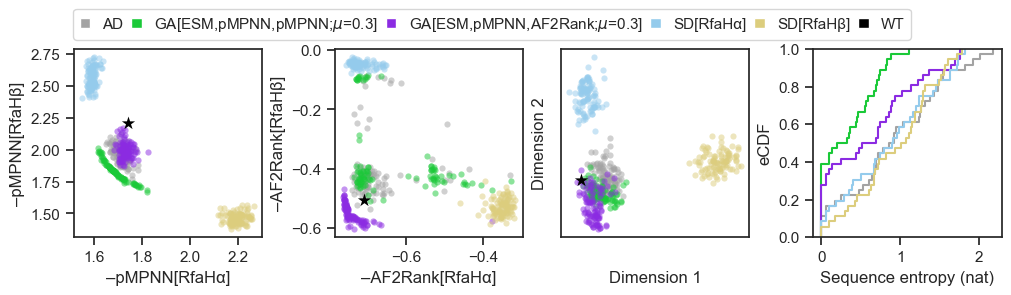

In [39]:
alpha= 0.5
s= 20

fig, axes= plt.subplots(1, 4, figsize= (10, 2.5), layout= 'constrained')

x_data= 'protein_mpnn_neg_log_prob_all_positions_chain_A'
y_data= 'protein_mpnn_neg_log_prob_all_positions_chain_B'
ax= axes[0]
sns.scatterplot(data= df_AD_dict['df'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_GA_dict[ga_1_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_GA_dict[ga_2_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['A']['df'], x= x_data, y= y_data, label= 'ss_A', ax= ax, color= cb_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['B']['df'], x= x_data, y= y_data, label= 'ss_B', ax= ax, color= cb_colors[5], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(x= [wt_data[x_data]], y= [wt_data[y_data]], label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= '–pMPNN[RfaHα]', ylabel= '–pMPNN[RfaHβ]'
)
ax.get_legend().remove()
#ax.set_aspect('equal')


x_data= 'neg_af2rank_composite_chain_A_model_1_ptm'
y_data= 'neg_af2rank_composite_chain_B_model_1_ptm'
ax= axes[1]
sns.scatterplot(data= df_AD_dict['df'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_GA_dict[ga_1_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_GA_dict[ga_2_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['A']['df'], x= x_data, y= y_data, label= 'ss_A', ax= ax, color= cb_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['B']['df'], x= x_data, y= y_data, label= 'ss_B', ax= ax, color= cb_colors[5], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(x= [wt_data[x_data]], y= [wt_data[y_data]], label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= '–AF2Rank[RfaHα]', ylabel= '–AF2Rank[RfaHβ]'
)
ax.get_legend().remove()
#ax.set_aspect('equal')

ax= axes[2]
x_data= 'seq_embed_1'
y_data= 'seq_embed_2'
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == f'GA_{ga_1_idx}'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == f'GA_{ga_2_idx}'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'ss_A'], x= x_data, y= y_data, label= 'ss_A', ax= ax, color= cb_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'ss_B'], x= x_data, y= y_data, label= 'ss_B', ax= ax, color= cb_colors[5], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_df[embedding_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)

ax.set(
    xlabel= 'Dimension 1', ylabel= 'Dimension 2',
    xticks= [], xticklabels= [], yticks= [], yticklabels= []
)
ax.get_legend().remove()
#ax.set_aspect('equal')

ax= axes[3]
sns.ecdfplot(x= entropy_AD, ax= ax, color= bright_colors[-3])
sns.ecdfplot(x= entropy_GA1, ax= ax, color= bright_colors[2])
sns.ecdfplot(x= entropy_GA2, ax= ax, color= bright_colors[4])
sns.ecdfplot(x= entropy_ss_A, ax= ax, color= cb_colors[4])
sns.ecdfplot(x= entropy_ss_B, ax= ax, color= cb_colors[5])

ax.set(xlabel= 'Sequence entropy (nat)', ylabel= 'eCDF')

#plt.legend(loc= 'lower right')

fig.align_labels()

handles= [
    mpatches.Patch(facecolor= bright_colors[-3], label= 'AD'),
    mpatches.Patch(facecolor= bright_colors[2], label= r'GA[ESM,pMPNN,pMPNN;$\mu$=0.3]'),
    mpatches.Patch(facecolor= bright_colors[4], label= r'GA[ESM,pMPNN,AF2Rank;$\mu$=0.3]'),
    mpatches.Patch(facecolor= cb_colors[4], label= 'SD[RfaHα]'),
    mpatches.Patch(facecolor= cb_colors[5], label= 'SD[RfaHβ]'),
    mpatches.Patch(facecolor= (0, 0, 0), label= 'WT')
]

fig.legend(
    handles= handles,
    bbox_to_anchor= (0.06, 1.15), loc= 'upper left',
    ncol= 6, columnspacing= 0.5, handlelength= 0.7
)

plt.show()

#fig.savefig('./RfaH_benchmark_scatter.svg', bbox_inches='tight', dpi= 600)

/tmp/ipykernel_81429/1438555515.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/1438555515.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/1438555515.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)


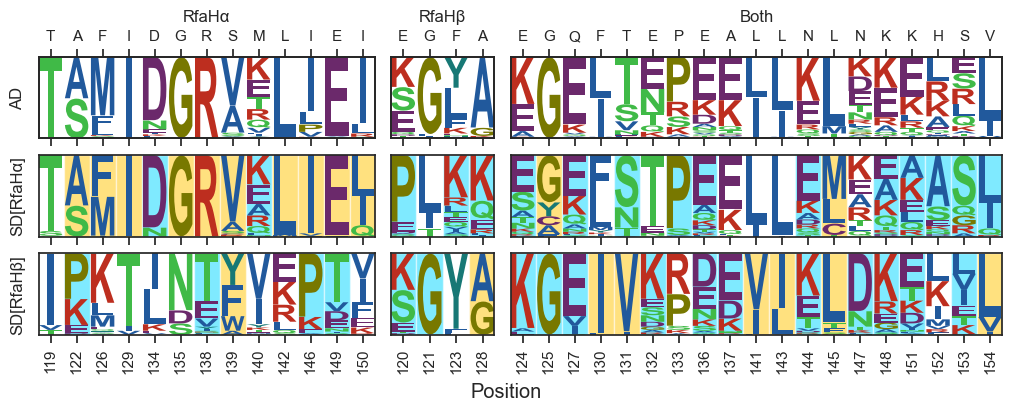

In [40]:
group1_resids= [119, 122, 126, 129, 134, 135, 138, 139, 140, 142, 146, 149, 150]
group2_resids= [120, 121, 123, 128]
group3_resids= [124, 125, 127, 130, 131, 132, 133, 136, 137, 141, 143, 144, 145, 147, 148, 151, 152, 153, 154]
assert len(set(group1_resids + group2_resids + group3_resids)) == len(all_resids)
assert len(group1_resids + group2_resids + group3_resids) == len(all_resids)

group_titles= ['RfaHα', 'RfaHβ', 'Both']

groups= [group1_resids, group2_resids, group3_resids]

plt_width= 10
width_ratios= np.array([len(resids) for resids in groups])
width_ratios= 10*width_ratios/np.sum(width_ratios)

fig, axes= plt.subplots(3, len(groups), figsize= (plt_width, 4), sharey= 'row', sharex= 'col', width_ratios= width_ratios, layout= 'constrained')

for idx, group_resids in enumerate(groups):

    logo_AD= logomaker.Logo(msa_AD.loc[group_resids].reset_index(drop= True), ax= axes[0, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    logo_ss_A= logomaker.Logo(msa_ss_A.loc[group_resids].reset_index(drop= True), ax= axes[1, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    logo_ss_B= logomaker.Logo(msa_ss_B.loc[group_resids].reset_index(drop= True), ax= axes[2, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

    if idx == 0:
        logo_AD.ax.set(ylabel= 'AD')
        logo_ss_A.ax.set(ylabel= 'SD[RfaHα]')
        logo_ss_B.ax.set(ylabel= 'SD[RfaHβ]')

    ax2= logo_AD.ax.twiny()
    ax2.set_xlim(logo_AD.ax.get_xlim())
    wt_aa_label= np.array(list(wt_data['candidate']))[np.concatenate([np.where(all_resids == idx) for idx in group_resids]).squeeze()]
    ax2.set_xticklabels(wt_aa_label)
    ax2.set_xticks(list(range(len(group_resids))))
    
    logo_AD.ax.set(yticks= [], yticklabels= [])
    logo_ss_A.ax.set(yticks= [], yticklabels= [])
    logo_ss_B.ax.set(yticks= [], yticklabels= [])

    logo_AD.ax.set(title= group_titles[idx])

    logo_ss_B.ax.set_xticks(list(range(len(group_resids))), group_resids, rotation= 90, ha= 'center')

    exposed_color= sns.color_palette('bright')[-1]
    buried_color= sns.color_palette('bright')[-2]
    highlight_alpha= 0.5

    for idx, rsa in rsa_A[rsa_A['Resid'].isin(group_resids)].reset_index(drop= True).iterrows():
        if rsa['In/Out'] == 'i':
            logo_ss_A.highlight_position(p= int(idx), color= buried_color, alpha= highlight_alpha)
        if rsa['In/Out'] == 'o':
            logo_ss_A.highlight_position(p= int(idx), color= exposed_color, alpha= highlight_alpha)

    for idx, rsa in rsa_B[rsa_B['Resid'].isin(group_resids)].reset_index(drop= True).iterrows():
        if rsa['In/Out'] == 'i':
            logo_ss_B.highlight_position(p= int(idx), color= buried_color, alpha= highlight_alpha)
        if rsa['In/Out'] == 'o':
            logo_ss_B.highlight_position(p= int(idx), color= exposed_color, alpha= highlight_alpha)

fig.supxlabel('Position')

fig.align_ylabels()

plt.show()

#fig.savefig('./RfaH_logo_ss_vs_ad.svg', bbox_inches='tight', dpi= 600)

/tmp/ipykernel_81429/2293008247.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/2293008247.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/2293008247.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/2293008247.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)


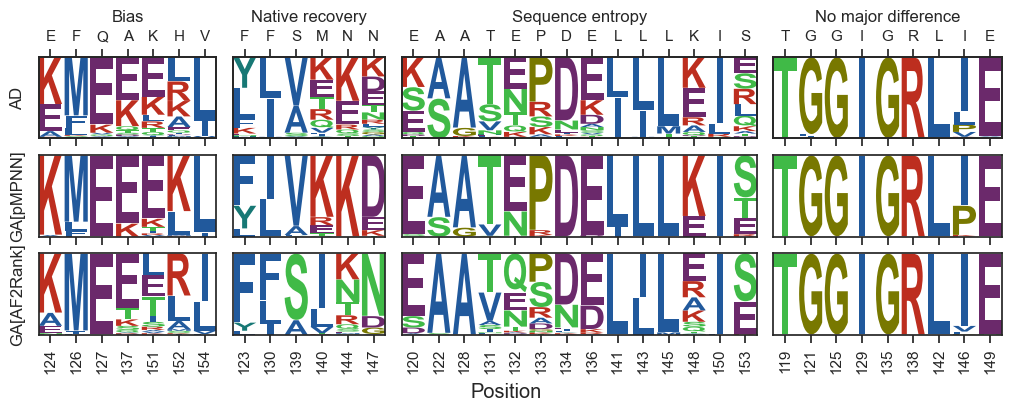

In [41]:
group1_resids= [124, 126, 127, 137, 151, 152, 154]
group2_resids= [123, 130, 139, 140, 144, 147]
group3_resids= [120, 122, 128, 131, 132, 133, 134, 136, 141, 143, 145, 148, 150, 153]
group4_resids= [119, 121, 125, 129, 135, 138, 142, 146, 149]
assert len(set(group1_resids + group2_resids + group3_resids + group4_resids)) == len(all_resids)
assert len(group1_resids + group2_resids + group3_resids + group4_resids) == len(all_resids)

group_titles= ['Bias', 'Native recovery', 'Sequence entropy', 'No major difference']

groups= [group1_resids, group2_resids, group3_resids, group4_resids]

plt_width= 10
width_ratios= np.array([len(resids) for resids in groups])
width_ratios= 10*width_ratios/np.sum(width_ratios)

fig, axes= plt.subplots(3, len(groups), figsize= (plt_width, 4), sharey= 'row', sharex= 'col', width_ratios= width_ratios, layout= 'constrained')

for idx, group_resids in enumerate(groups):

    logo_AD= logomaker.Logo(msa_AD.loc[group_resids].reset_index(drop= True), ax= axes[0, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    logo_GA1= logomaker.Logo(msa_GA1.loc[group_resids].reset_index(drop= True), ax= axes[1, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    logo_GA2= logomaker.Logo(msa_GA2.loc[group_resids].reset_index(drop= True), ax= axes[2, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

    if idx == 0:
        logo_AD.ax.set(ylabel= 'AD')
        logo_GA1.ax.set(ylabel= 'GA[pMPNN]')
        logo_GA2.ax.set(ylabel= 'GA[AF2Rank]')

    ax2= logo_AD.ax.twiny()
    ax2.set_xlim(logo_AD.ax.get_xlim())
    wt_aa_label= np.array(list(wt_data['candidate']))[np.concatenate([np.where(all_resids == idx) for idx in group_resids]).squeeze()]
    ax2.set_xticklabels(wt_aa_label)
    ax2.set_xticks(list(range(len(group_resids))))
    
    logo_AD.ax.set(yticks= [], yticklabels= [])
    logo_GA1.ax.set(yticks= [], yticklabels= [])
    logo_GA2.ax.set(yticks= [], yticklabels= [])

    logo_AD.ax.set(title= group_titles[idx])

    logo_GA2.ax.set_xticks(list(range(len(group_resids))), group_resids, rotation= 90, ha= 'center')

fig.supxlabel('Position')

fig.align_ylabels()

plt.show()

#fig.savefig('./RfaH_logo_ad_vs_ga.svg', bbox_inches='tight', dpi= 600)

Pairwise correlations of objective functions

In [42]:
ga_1_idx= 31
ga_2_idx= ga_1_idx + 7

new_df_list= []
for df, method in zip([df_AD_dict['df'], df_GA_dict[ga_1_idx]['df'][-1], df_GA_dict[ga_2_idx]['df'][-1]], ['AD', 'GA[pMPNN]', 'GA[AF2Rank]']):
    new_df= df[[
        'protein_mpnn_neg_log_prob_all_positions_chain_A',
        'neg_af2rank_composite_chain_A_model_1_ptm',
        'protein_mpnn_neg_log_prob_all_positions_chain_B',
        'neg_af2rank_composite_chain_B_model_1_ptm', 
        'neg_esm1v_chain_A',
        'identity'
    ]]
    new_df.columns= ['–pMPNN[RfaHα]', '–AF2Rank[RfaHα]', '–pMPNN[RfaHβ]', '–AF2Rank[RfaHβ]', '–ESM-1v', 'Nat. seq. recov.']
    new_df['method']= method

    new_df_list.append(new_df)

new_dfs= pd.concat(new_df_list)

/tmp/ipykernel_81429/1052478593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['method']= method
/tmp/ipykernel_81429/1052478593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['method']= method
/tmp/ipykernel_81429/1052478593.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

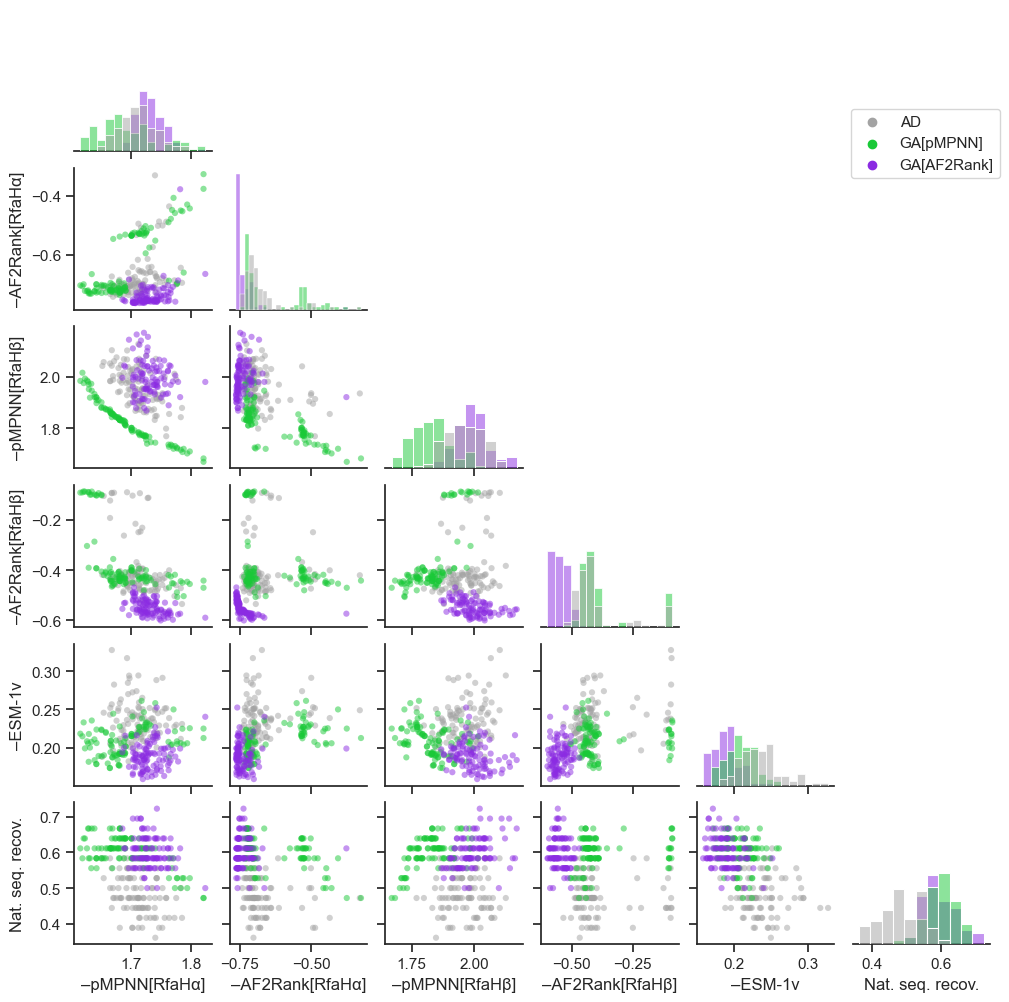

In [43]:
fig_pairplot= sns.pairplot(
    data= new_dfs,
    hue= 'method',
    palette= [bright_colors[idx] for idx in [-3, 2, 4]],
    corner= True,
    plot_kws= {'alpha': 0.5, 's': 20, 'linewidth': 0},
    diag_kind= 'hist',
    height= 1.7,
    aspect= 1
)

fig_pairplot.fig.align_ylabels()
sns.move_legend(fig_pairplot, "center", bbox_to_anchor=(0.8, 0.85), ncol=1, title=None, frameon=True)

plt.show()

#fig_pairplot.fig.savefig('./RfaH_pairplot_correlations.png', bbox_inches='tight', dpi= 600)

Investigation of sequence spreads in the AF2Rank objective space

In [44]:
ga_1_idx= 31
ga_2_idx= ga_1_idx + 7

af2rank_chain_A_cutoff= -0.6
af2rank_chain_B_cutoff= -0.3

In [45]:
df= df_GA_dict[ga_1_idx]['df'][-1]
msa_GA1_mode= logomaker.alignment_to_matrix(df['candidate'][(df['neg_af2rank_composite_chain_A_model_1_ptm'] < af2rank_chain_A_cutoff) & (df['neg_af2rank_composite_chain_B_model_1_ptm'] < af2rank_chain_B_cutoff)], to_type= 'counts')
msa_GA1_bad_alpha= logomaker.alignment_to_matrix(df['candidate'][df['neg_af2rank_composite_chain_A_model_1_ptm'] > af2rank_chain_A_cutoff], to_type= 'counts')
msa_GA1_bad_beta= logomaker.alignment_to_matrix(df['candidate'][df['neg_af2rank_composite_chain_B_model_1_ptm'] > af2rank_chain_B_cutoff], to_type= 'counts')

df= df_AD_dict['df']
msa_AD_mode= logomaker.alignment_to_matrix(df['candidate'][(df['neg_af2rank_composite_chain_A_model_1_ptm'] < af2rank_chain_A_cutoff) & (df['neg_af2rank_composite_chain_B_model_1_ptm'] < af2rank_chain_B_cutoff)], to_type= 'counts')
msa_AD_bad_alpha= logomaker.alignment_to_matrix(df['candidate'][df['neg_af2rank_composite_chain_A_model_1_ptm'] > af2rank_chain_A_cutoff], to_type= 'counts')
msa_AD_bad_beta= logomaker.alignment_to_matrix(df['candidate'][df['neg_af2rank_composite_chain_B_model_1_ptm'] > af2rank_chain_B_cutoff], to_type= 'counts')

msa_ss_A= logomaker.alignment_to_matrix(df_ss_dict['A']['df']['candidate'], to_type= 'counts')
msa_ss_B= logomaker.alignment_to_matrix(df_ss_dict['B']['df']['candidate'], to_type= 'counts')

all_resids= np.array(list(range(119, 155)))
all_resids_idx= pd.Index(all_resids, name= 'pos')

msa_GA1_mode.index= all_resids_idx
msa_GA1_bad_alpha.index= all_resids_idx
msa_GA1_bad_beta.index= all_resids_idx
msa_AD_mode.index= all_resids_idx
msa_AD_bad_alpha.index= all_resids_idx
msa_AD_bad_beta.index= all_resids_idx
msa_ss_A.index= all_resids_idx
msa_ss_B.index= all_resids_idx

/tmp/ipykernel_81429/3378855016.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)


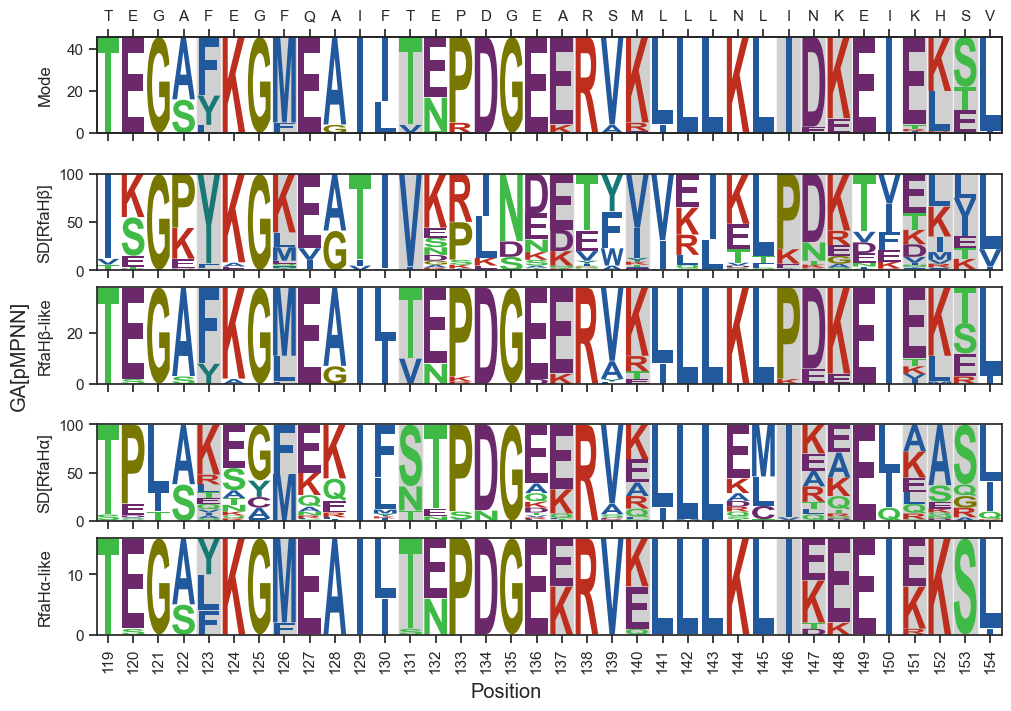

In [46]:
fig, axes= plt.subplots(7, 1, figsize= (10, 7), layout= 'constrained', sharex= True, height_ratios= [1, 0.1, 1, 1, 0.1, 1, 1])

logo_GA1_mode= logomaker.Logo(msa_GA1_mode, ax= axes[0], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

axes[1].axis('off')

logo_ss_B= logomaker.Logo(msa_ss_B, ax= axes[2], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
logo_GA1_bad_alpha= logomaker.Logo(msa_GA1_bad_alpha, ax= axes[3], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

axes[4].axis('off')

logo_ss_A= logomaker.Logo(msa_ss_A, ax= axes[5], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
logo_GA1_bad_beta= logomaker.Logo(msa_GA1_bad_beta, ax= axes[6], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

logo_GA1_bad_beta.ax.set_xticks(all_resids, all_resids, rotation= 90, ha= 'center')

logo_GA1_mode.ax.set(ylabel= 'Mode')
logo_ss_B.ax.set(ylabel= 'SD[RfaHβ]')
logo_GA1_bad_alpha.ax.set(ylabel= 'RfaHβ-like')
logo_ss_A.ax.set(ylabel= 'SD[RfaHα]')
logo_GA1_bad_beta.ax.set(ylabel= 'RfaHα-like')

ax2= logo_GA1_mode.ax.twiny()
ax2.set_xlim(logo_GA1_mode.ax.get_xlim())
wt_aa_label= list(wt_data['candidate'])
ax2.set_xticklabels(wt_aa_label)
ax2.set_xticks(all_resids)

fig.supxlabel('Position')
fig.supylabel('GA[pMPNN]')

highlight_color= sns.color_palette('bright')[-3]
highlight_alpha= 0.5
highlight_positions= [123, 126, 131, 137, 140, 146, 147, 148, 151, 152, 153]
for idx in highlight_positions:
    logo_GA1_mode.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_ss_B.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_GA1_bad_alpha.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_ss_A.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_GA1_bad_beta.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)

fig.align_ylabels()

plt.show()

#fig.savefig('./GA_pMPNN_AF2Rank_scatter_seq_compare.png', bbox_inches='tight', dpi= 600)

AD low temperature comparison plot

In [47]:
df_GA_1_dict_list= [df_GA_dict[idx] for idx in [29, 31, 33, 35]]
df_GA_2_dict_list= [df_GA_dict[idx] for idx in [36, 38, 40, 42]]
mu_list= [0.1, 0.3, 0.5, 0.7]

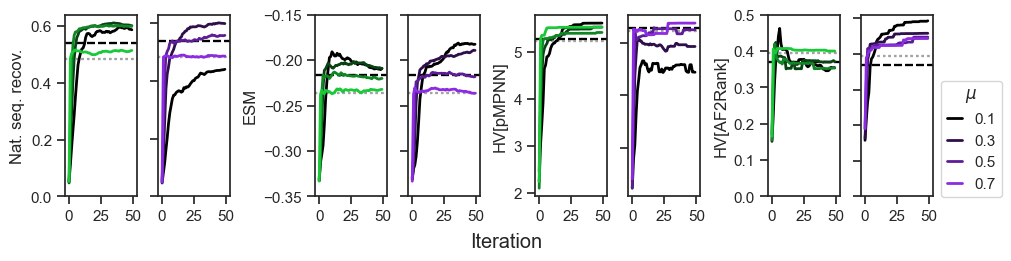

In [48]:
fig, axes= plt.subplots(1, 8, figsize= (10, 2.5), sharex= True, layout= 'constrained')

color_idx= 0
for metric_idx, metric in enumerate(['identity', 'esm', 'hv_protein_mpnn', 'hv_af2rank']):
    for mu_idx, (mu, df1, df2) in enumerate(zip(mu_list, df_GA_1_dict_list, df_GA_2_dict_list)):
        for idx, data_dict in enumerate([df1, df2]):
            ax= axes[2*metric_idx + idx]

            ax.axhline(df_AD_dict[metric], color= bright_colors[-3], linestyle= 'dotted', zorder= 0)
            ax.axhline(df_AD_low_temp_dict[metric], color= 'black', linestyle= 'dashed', zorder= 0)

            y_data= data_dict[metric]
            x_data= list(range(len(y_data)))
            sns.lineplot(
                x= x_data, y= y_data,
                linewidth= 2,
                color= hex_interpolate(
                    [0, 0, 0], 
                    bright_colors[2] if idx == 0 else bright_colors[4], 
                    mu_idx/(len(mu_list) - 1)
                ),
                label= mu,
                ax= ax
            )
            color_idx+= 1

            ax.set(
                xlim= [-3, 53],
                xticks= [0, 25, 50]
            )
            if metric_idx == 0:
                ax.set(yticks= [0., 0.2, 0.4, 0.6])
            elif metric_idx == 1:
                ax.set(yticks= [-0.35, -0.3, -0.25, -0.2, -0.15])
            elif metric_idx == 3:
                ax.set(yticks= [0., 0.1, 0.2, 0.3, 0.4, 0.5])

            ax.get_legend().remove()

            if idx == 1:
                ax.set(yticklabels= [])

axes[0].set(
    ylabel= 'Nat. seq. recov.'
)
axes[2].set(
    ylabel= 'ESM'
)
axes[4].set(
    ylabel= 'HV[pMPNN]'
)
axes[6].set(
    ylabel= 'HV[AF2Rank]'
)

ax= axes[7]
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(
    legend_handles, mu_list, title= r'$\mu$',
    bbox_to_anchor= (1, 0.68), loc= 'upper left',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

fig.align_labels()
fig.supxlabel('Iteration')

plt.show()

#fig.savefig('./RfaH_GA_benchmark_stats_low_T.png', bbox_inches='tight', dpi= 600)

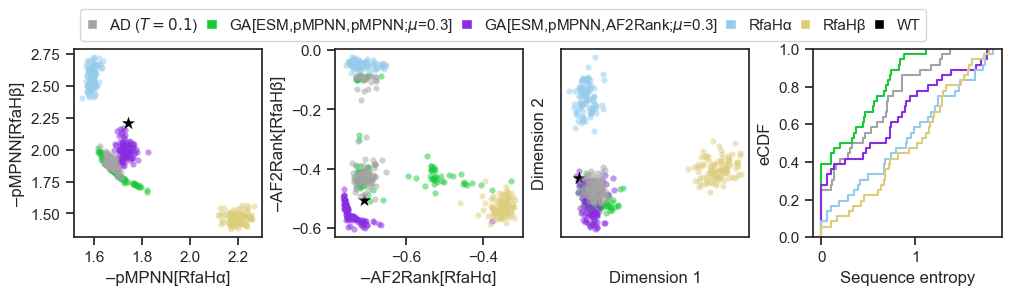

In [49]:
candidates= []
methods= []

new_candidates= list(df_GA_dict[ga_1_idx]['df'][-1]['candidate'].values)
methods+= [f'GA_{ga_1_idx}']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_GA_dict[ga_2_idx]['df'][-1]['candidate'].values)
methods+= [f'GA_{ga_2_idx}']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_AD_low_temp_dict['df']['candidate'].values)
methods+= ['AD']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_ss_dict['A']['df']['candidate'].values)
methods+= ['ss_A']*len(new_candidates)
candidates+= new_candidates

new_candidates= list(df_ss_dict['B']['df']['candidate'].values)
methods+= ['ss_B']*len(new_candidates)
candidates+= new_candidates

candidates+= [wt_data['candidate']]
methods+= ['WT']

candidates_df= pd.DataFrame({'candidate': candidates, 'method': methods})

blosum_matrix= []
for candidate_1, method_1 in zip(candidates_df['candidate'], candidates_df['method']):
    blosum_dists= []
    for candidate_2, method_2 in zip(candidates_df['candidate'], candidates_df['method']):
        blosum_dist= aligner.align(str(candidate_1), str(candidate_2)).score/len(candidate_1)
        blosum_dists.append(blosum_dist)
    blosum_matrix.append(blosum_dists)
blosum_matrix= np.asarray(blosum_matrix)

embedding = SpectralEmbedding(n_components=2, affinity= 'precomputed')
blosum_matrix_transformed = embedding.fit_transform(blosum_matrix)

embedding_low_temp_df= pd.DataFrame({'seq_embed_1': blosum_matrix_transformed[:, 0], 'seq_embed_2': blosum_matrix_transformed[:, 1], 'method': candidates_df['method']})


alpha= 0.5
s= 20

fig, axes= plt.subplots(1, 4, figsize= (10, 2.5), layout= 'constrained')

x_data= 'protein_mpnn_neg_log_prob_all_positions_chain_A'
y_data= 'protein_mpnn_neg_log_prob_all_positions_chain_B'
ax= axes[0]
sns.scatterplot(data= df_AD_low_temp_dict['df'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0, zorder= 10)
sns.scatterplot(data= df_GA_dict[ga_1_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_GA_dict[ga_2_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['A']['df'], x= x_data, y= y_data, label= 'ss_A', ax= ax, color= cb_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['B']['df'], x= x_data, y= y_data, label= 'ss_B', ax= ax, color= cb_colors[5], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(x= [wt_data[x_data]], y= [wt_data[y_data]], label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= '–pMPNN[RfaHα]', ylabel= '–pMPNN[RfaHβ]'
)
ax.get_legend().remove()
#ax.set_aspect('equal')


x_data= 'neg_af2rank_composite_chain_A_model_1_ptm'
y_data= 'neg_af2rank_composite_chain_B_model_1_ptm'
ax= axes[1]
sns.scatterplot(data= df_AD_low_temp_dict['df'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0, zorder= 10)
sns.scatterplot(data= df_GA_dict[ga_1_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_GA_dict[ga_2_idx]['df'][-1], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['A']['df'], x= x_data, y= y_data, label= 'ss_A', ax= ax, color= cb_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= df_ss_dict['B']['df'], x= x_data, y= y_data, label= 'ss_B', ax= ax, color= cb_colors[5], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(x= [wt_data[x_data]], y= [wt_data[y_data]], label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)
ax.set(
    xlabel= '–AF2Rank[RfaHα]', ylabel= '–AF2Rank[RfaHβ]'
)
ax.get_legend().remove()
#ax.set_aspect('equal')

ax= axes[2]
x_data= 'seq_embed_1'
y_data= 'seq_embed_2'
sns.scatterplot(data= embedding_low_temp_df[embedding_low_temp_df['method'] == 'AD'], x= x_data, y= y_data, label= 'AD', ax= ax, color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0, zorder= 10)
sns.scatterplot(data= embedding_low_temp_df[embedding_low_temp_df['method'] == f'GA_{ga_1_idx}'], x= x_data, y= y_data, label= 'GA_31', ax= ax, color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_low_temp_df[embedding_low_temp_df['method'] == f'GA_{ga_2_idx}'], x= x_data, y= y_data, label= 'GA_38', ax= ax, color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_low_temp_df[embedding_low_temp_df['method'] == 'ss_A'], x= x_data, y= y_data, label= 'ss_A', ax= ax, color= cb_colors[4], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_low_temp_df[embedding_low_temp_df['method'] == 'ss_B'], x= x_data, y= y_data, label= 'ss_B', ax= ax, color= cb_colors[5], alpha= alpha, s= s, linewidth= 0)
sns.scatterplot(data= embedding_low_temp_df[embedding_low_temp_df['method'] == 'WT'], x= x_data, y= y_data, label= 'WT', marker= "*", ax= ax, color= 'black', alpha= 1., s= 5*s, linewidth= 0)

ax.set(
    xlabel= 'Dimension 1', ylabel= 'Dimension 2',
    xticks= [], xticklabels= [], yticks= [], yticklabels= []
)
ax.get_legend().remove()


ax= axes[3]
sns.ecdfplot(x= entropy_AD_low_temp, ax= ax, color= bright_colors[-3])
sns.ecdfplot(x= entropy_GA1, ax= ax, color= bright_colors[2])
sns.ecdfplot(x= entropy_GA2, ax= ax, color= bright_colors[4])
sns.ecdfplot(x= entropy_ss_A, ax= ax, color= cb_colors[4])
sns.ecdfplot(x= entropy_ss_B, ax= ax, color= cb_colors[5])

ax.set(xlabel= 'Sequence entropy', ylabel= 'eCDF')

#plt.legend(loc= 'lower right')

fig.align_labels()

handles= [
    mpatches.Patch(facecolor= bright_colors[-3], label= 'AD ($T=0.1$)'),
    mpatches.Patch(facecolor= bright_colors[2], label= r'GA[ESM,pMPNN,pMPNN;$\mu$=0.3]'),
    mpatches.Patch(facecolor= bright_colors[4], label= r'GA[ESM,pMPNN,AF2Rank;$\mu$=0.3]'),
    mpatches.Patch(facecolor= cb_colors[4], label= 'RfaHα'),
    mpatches.Patch(facecolor= cb_colors[5], label= 'RfaHβ'),
    mpatches.Patch(facecolor= (0, 0, 0), label= 'WT')
]

fig.legend(
    handles= handles,
    bbox_to_anchor= (0.067, 1.15), loc= 'upper left',
    ncol= 6, columnspacing= 0.5, handlelength= 0.7
)

plt.show()

#fig.savefig('./RfaH_benchmark_scatter_low_T.png', bbox_inches='tight', dpi= 600)

/tmp/ipykernel_81429/1197344096.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/1197344096.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/1197344096.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)
/tmp/ipykernel_81429/1197344096.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)


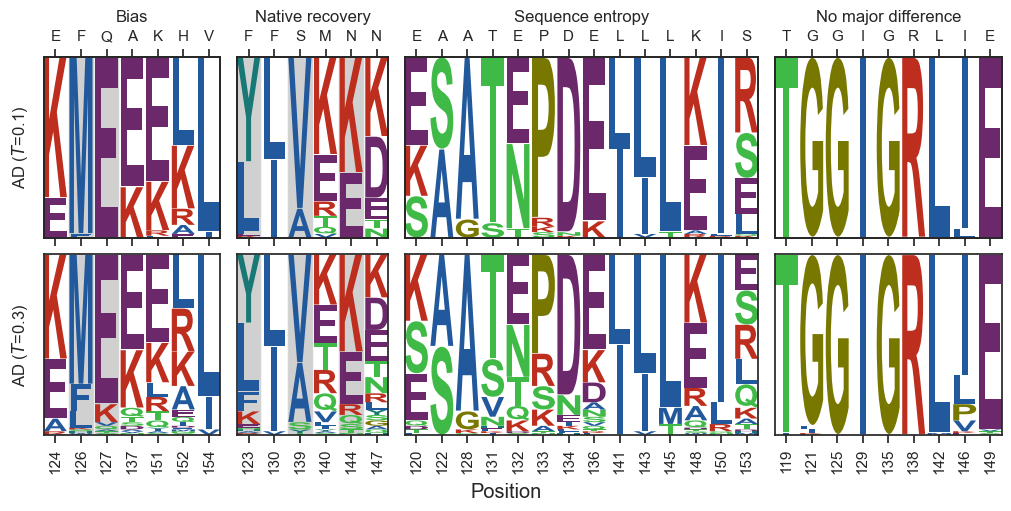

In [51]:
group1_resids= [124, 126, 127, 137, 151, 152, 154]
group2_resids= [123, 130, 139, 140, 144, 147]
group3_resids= [120, 122, 128, 131, 132, 133, 134, 136, 141, 143, 145, 148, 150, 153]
group4_resids= [119, 121, 125, 129, 135, 138, 142, 146, 149]
assert len(set(group1_resids + group2_resids + group3_resids + group4_resids)) == len(all_resids)
assert len(group1_resids + group2_resids + group3_resids + group4_resids) == len(all_resids)

group_titles= ['Bias', 'Native recovery', 'Sequence entropy', 'No major difference']

groups= [group1_resids, group2_resids, group3_resids, group4_resids]

plt_width= 10
width_ratios= np.array([len(resids) for resids in groups])
width_ratios= 10*width_ratios/np.sum(width_ratios)

fig, axes= plt.subplots(2, len(groups), figsize= (plt_width, 5), sharey= 'row', sharex= 'col', width_ratios= width_ratios, layout= 'constrained')

for idx, group_resids in enumerate(groups):

    logo_AD_low_temp= logomaker.Logo(msa_AD_low_temp.loc[group_resids].reset_index(drop= True), ax= axes[0, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
    logo_AD= logomaker.Logo(msa_AD.loc[group_resids].reset_index(drop= True), ax= axes[1, idx], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

    if idx == 0:
        logo_AD_low_temp.ax.set(ylabel= 'AD ($T$=0.1)')
        logo_AD.ax.set(ylabel= 'AD ($T$=0.3)')

    ax2= logo_AD_low_temp.ax.twiny()
    ax2.set_xlim(logo_AD_low_temp.ax.get_xlim())
    wt_aa_label= np.array(list(wt_data['candidate']))[np.concatenate([np.where(all_resids == idx) for idx in group_resids]).squeeze()]
    ax2.set_xticklabels(wt_aa_label)
    ax2.set_xticks(list(range(len(group_resids))))
    
    logo_AD_low_temp.ax.set(yticks= [], yticklabels= [])
    logo_AD.ax.set(yticks= [], yticklabels= [])

    logo_AD_low_temp.ax.set(title= group_titles[idx])

    logo_AD.ax.set_xticks(list(range(len(group_resids))), group_resids, rotation= 90, ha= 'center')

    highlight_color= sns.color_palette('bright')[-3]
    highlight_alpha= 0.5

    
    for resid in [127, 139, 144, 123, 126]:
        if resid in group_resids:
            logo_AD_low_temp.highlight_position(p= group_resids.index(resid), color= highlight_color, alpha= highlight_alpha)
            logo_AD.highlight_position(p= group_resids.index(resid), color= highlight_color, alpha= highlight_alpha)

fig.supxlabel('Position')

fig.align_ylabels()

plt.show()

#fig.savefig('./RfaH_logo_ad_vs_ga_low_T.png', bbox_inches='tight', dpi= 600)

Random seed reproducibility analysis

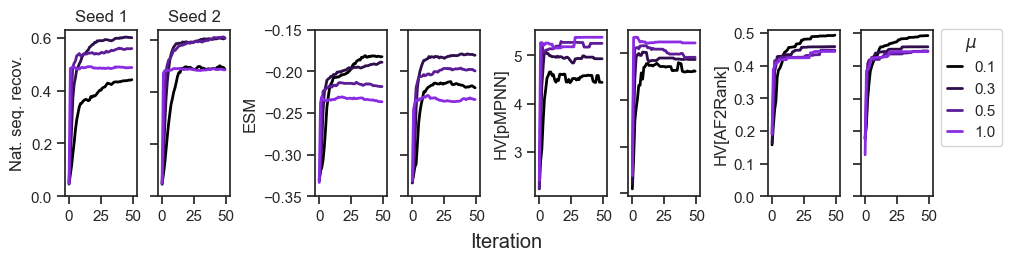

In [72]:
fig, axes= plt.subplots(1, 8, figsize= (10, 2.5), sharex= True, layout= 'constrained')

mu_list= [0.1, 0.3, 0.5, 1.0]

for metric_idx, metric in enumerate(['identity', 'esm', 'hv_protein_mpnn', 'hv_af2rank']):
    for seed_idx, seed_dict in enumerate(df_GA_repro_dict.values()):
        ax= axes[2*metric_idx + seed_idx]
        for (mu_idx, mu), data_dict in zip(enumerate(mu_list), seed_dict.values()):
            y_data= data_dict[metric]
            x_data= list(range(len(y_data)))
            sns.lineplot(
                x= x_data, y= y_data,
                linewidth= 2,
                color= hex_interpolate(
                    [0, 0, 0], 
                    bright_colors[4], 
                    mu_idx/(len(mu_list) - 1)
                ),
                label= mu,
                ax= ax
            )

        ax.set(
            xlim= [-3, 53],
            xticks= [0, 25, 50]
        )
        if metric_idx == 0:
            ax.set(yticks= [0., 0.2, 0.4, 0.6])
        elif metric_idx == 1:
            ax.set(yticks= [-0.35, -0.3, -0.25, -0.2, -0.15])
        elif metric_idx == 3:
            ax.set(yticks= [0., 0.1, 0.2, 0.3, 0.4, 0.5])

        if seed_idx == 1:
            ax.set(yticklabels= [])

        ax.get_legend().remove()

axes[0].set(
    ylabel= 'Nat. seq. recov.'
)
axes[2].set(
    ylabel= 'ESM'
)
axes[4].set(
    ylabel= 'HV[pMPNN]'
)
axes[6].set(
    ylabel= 'HV[AF2Rank]'
)

axes[0].set(title= 'Seed 1')
axes[1].set(title= 'Seed 2')

fig.align_labels()
fig.supxlabel('Iteration')

ax= axes[7]
legend_handles, _= ax.get_legend_handles_labels()
ax.legend(
    legend_handles, mu_list, title= r'$\mu$',
    bbox_to_anchor= (1, 1.05), loc= 'upper left',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

plt.show()

#fig.savefig('./random_seed_progression.png', bbox_inches='tight', dpi= 600)

In [73]:
ga_idx= 38

msa_GA_seed1= logomaker.alignment_to_matrix(df_GA_repro_dict['seed1'][ga_idx]['df'][-1]['candidate'], to_type= 'counts')
msa_GA_seed2= logomaker.alignment_to_matrix(df_GA_repro_dict['seed2'][ga_idx]['df'][-1]['candidate'], to_type= 'counts')

all_resids= np.array(list(range(119, 155)))
all_resids_idx= pd.Index(all_resids, name= 'pos')
msa_GA_seed1.index= all_resids_idx
msa_GA_seed2.index= all_resids_idx

/tmp/ipykernel_81429/4159076341.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(wt_aa_label)


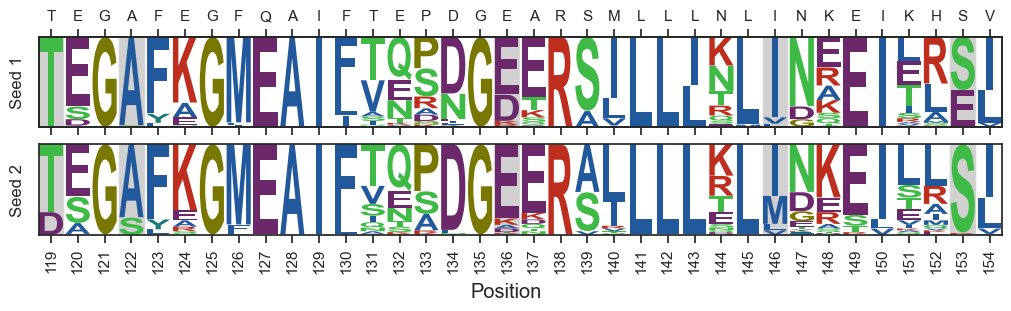

In [74]:
fig, axes= plt.subplots(2, 1, figsize= (10, 3), layout= 'constrained', sharex= True)

logo_GA_seed1= logomaker.Logo(msa_GA_seed1, ax= axes[0], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)
logo_GA_seed2= logomaker.Logo(msa_GA_seed2, ax= axes[1], color_scheme= 'NajafabadiEtAl2017', vpad= 0.01, width= 0.9)

logo_GA_seed2.ax.set_xticks(all_resids, all_resids, rotation= 90, ha= 'center')

logo_GA_seed1.ax.set(ylabel= 'Seed 1', yticks= [])
logo_GA_seed2.ax.set(ylabel= 'Seed 2', yticks= [])

ax2= logo_GA_seed1.ax.twiny()
ax2.set_xlim(logo_GA_seed1.ax.get_xlim())
wt_aa_label= list(wt_data['candidate'])
ax2.set_xticklabels(wt_aa_label)
ax2.set_xticks(all_resids)

fig.supxlabel('Position')

highlight_color= sns.color_palette('bright')[-3]
highlight_alpha= 0.5
highlight_positions= [119, 122, 136, 146, 153]
for idx in highlight_positions:
    logo_GA_seed1.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)
    logo_GA_seed2.highlight_position(p= idx, color= highlight_color, alpha= highlight_alpha)

plt.show()

#fig.savefig('./random_seed_logo.png', bbox_inches='tight', dpi= 600)

F130 AD decoding weight analysis

In [75]:
# https://stackoverflow.com/a/39402483
from math import atan2,degrees
import numpy as np

#Label line with line2D label data
def labelLine(line,x,label=None,align=True,**kwargs):

    ax = line.axes
    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if (x < xdata[0]) or (x > xdata[-1]):
        print('x label location is outside data range!')
        return

    #Find corresponding y co-ordinate and angle of the line
    ip = 1
    for i in range(len(xdata)):
        if x < xdata[i]:
            ip = i
            break

    y = ydata[ip-1] + (ydata[ip]-ydata[ip-1])*(x-xdata[ip-1])/(xdata[ip]-xdata[ip-1])

    if not label:
        label = line.get_label()

    if align:
        #Compute the slope
        dx = xdata[ip] - xdata[ip-1]
        dy = ydata[ip] - ydata[ip-1]
        ang = degrees(atan2(dy,dx))

        #Transform to screen co-ordinates
        pt = np.array([x,y]).reshape((1,2))
        trans_angle = ax.transData.transform_angles(np.array((ang,)),pt)[0]

    else:
        trans_angle = 0

    #Set a bunch of keyword arguments
    if 'color' not in kwargs:
        kwargs['color'] = line.get_color()

    if ('horizontalalignment' not in kwargs) and ('ha' not in kwargs):
        kwargs['ha'] = 'center'

    if ('verticalalignment' not in kwargs) and ('va' not in kwargs):
        kwargs['va'] = 'center'

    if 'backgroundcolor' not in kwargs:
        kwargs['backgroundcolor'] = ax.get_facecolor()

    if 'clip_on' not in kwargs:
        kwargs['clip_on'] = True

    if 'zorder' not in kwargs:
        kwargs['zorder'] = 2.5

    ax.text(x,y,label,rotation=trans_angle,**kwargs)

def labelLines(lines,align=True,xvals=None,**kwargs):

    ax = lines[0].axes
    labLines = []
    labels = []

    #Take only the lines which have labels other than the default ones
    for line in lines:
        label = line.get_label()
        if "_line" not in label:
            labLines.append(line)
            labels.append(label)

    if xvals is None:
        xmin,xmax = ax.get_xlim()
        xvals = np.linspace(xmin,xmax,len(labLines)+2)[1:-1]

    for line,x,label in zip(labLines,xvals,labels):
        labelLine(line,x,label,align,**kwargs)

In [76]:
pmpnn_alphabet= list('ACDEFGHIKLMNPQRSTVWYX')

In [77]:
temp= 0.3
n_tied= 2

# F123
res123_logits_1= np.array([ 2.6584e-02, -2.9146e+00, -2.2994e+00,  8.4891e-03, -1.6492e-01,
         -3.3748e+00, -1.0944e+00,  4.4258e-01,  2.4293e+00,  1.5718e+00,
         -1.1459e+00, -1.5636e+00, -4.1408e+00,  2.5869e-01,  2.0541e+00,
         -2.2785e-02,  3.0410e-01,  1.3492e-04, -2.5984e+00,  1.6502e-01,
         -3.8837e+00])*temp*n_tied
res123_logits_2= np.array([-0.3611, -1.1482, -1.7341, -1.3869,  5.9442, -1.3968,  1.5619, -2.1535,
         -0.5713,  2.0383, -0.3033, -0.1102, -1.9742, -1.3577, -1.7489, -1.4139,
         -1.8798, -1.4431,  1.0855,  5.8232, -1.7619])*temp*n_tied

# F130
res130_logits_1= np.array([-1.2994, -2.1608, -2.1109, -2.0445,  2.5309, -3.2858, -2.1667,  1.6362,
          1.2279,  1.8138,  1.1502,  0.0385, -4.0932, -1.5686,  0.7103, -0.4797,
         -0.6444, -0.0400, -0.4681,  1.6249, -3.5938])*temp*n_tied

res130_logits_2= np.array([-1.7987, -1.2684, -1.9037, -1.7137, -0.7557, -1.8752, -1.9505,  5.8439,
         -1.7957,  5.2525,  0.3288, -1.7392, -1.9041, -1.7091, -1.1315, -1.6324,
         -1.3369,  4.5318, -0.9418, -0.3311, -1.6036])*temp*n_tied

# S139
res139_logits_1= np.array([ 1.0809,  1.5310, -3.5425, -2.9125, -3.0562, -0.9598, -3.0336, -3.1016,
          1.8230, -0.3087, -2.7507, -0.9324, -3.4464, -2.2788,  2.3208,  1.6046,
          0.6684,  3.1565, -3.0467, -2.1113, -3.4827])*temp*n_tied
res139_logits_2= np.array([ 1.5684, -0.7580, -2.9176, -3.2895,  2.8773, -2.4502,  0.4472, -2.3306,
         -0.1404, -2.8383, -0.7412, -0.9702, -3.6710, -0.4785, -0.2276,  0.4087,
         -1.5056,  0.2674,  3.0831,  3.5884, -3.2703])*temp*n_tied

# M140
res140_logits_1= np.array([ 1.2143, -3.0362, -0.3011,  1.7882, -2.7652, -1.1605, -1.2755, -0.8928,
          2.3202, -0.5420, -1.8064,  0.3639, -4.2233,  2.0212,  1.3868,  0.3904,
          0.7966, -0.4479, -3.5023, -2.5125, -3.8752])*temp*n_tied
res140_logits_2= np.array([-2.9360, -1.8283, -1.2528,  1.8047, -2.3527, -3.0588, -1.1353,  1.8478,
          0.0245, -0.8747, -1.6268, -0.7371, -3.8269,  1.2230,  0.1860, -1.5466,
          2.9300,  2.6756, -1.8004, -2.0907, -3.6039])*temp*n_tied

# N144
res144_logits_1= np.array([ 1.1017, -2.8469,  2.2164,  3.1339, -2.3696,  0.5648, -0.7332, -2.2662,
          1.5006, -1.4181, -1.9553,  1.4979, -3.2268,  1.2344,  0.4775,  1.5494,
          0.9222, -1.9864, -3.0125, -1.8552, -3.6618])*temp*n_tied
res144_logits_2= np.array([-1.6516, -2.8650, -1.7415,  0.7464, -1.7701, -2.4674,  0.0704, -1.6431,
          4.4988, -1.7479, -2.2050, -0.4704,  0.3353,  1.2600,  3.3311,  1.1066,
          1.7887, -0.8342, -3.1708, -1.9660, -3.3212])*temp*n_tied

# N147
res147_logits_1= np.array([ 0.9035, -2.7622,  0.5125,  1.8514, -1.7347, -0.5149,  0.1298, -1.4455,
          1.4723, -0.0889, -1.6271,  0.4733, -3.9998,  0.6480,  0.7551,  0.7634,
          0.6852, -1.2443, -3.0300, -1.5337, -4.1931])*temp*n_tied
res147_logits_2= np.array([-1.4589e+00, -2.7761e+00,  4.3983e+00,  1.3672e+00, -3.5745e-01,
          2.6231e+00, -4.7137e-01, -2.0903e+00,  6.1192e-01, -9.1277e-01,
         -1.7890e+00,  2.7721e+00, -2.6012e+00, -1.2308e+00,  3.3840e-03,
          3.0129e-01,  1.1079e+00, -2.0437e+00, -1.3209e+00, -6.5755e-01,
         -2.9563e+00])*temp*n_tied

logits_df= pd.DataFrame({
    'aa': pmpnn_alphabet, 
    '123_alpha': res123_logits_1,
    '123_beta': res123_logits_2,
    '130_alpha': res130_logits_1,
    '130_beta': res130_logits_2,
    '139_alpha': res139_logits_1,
    '139_beta': res139_logits_2,
    '140_alpha': res140_logits_1,
    '140_beta': res140_logits_2,
    '144_alpha': res144_logits_1,
    '144_beta': res144_logits_2,
    '147_alpha': res147_logits_1,
    '147_beta': res147_logits_2,
})

resid_list= [123, 130, 139, 140, 144, 147]

ave_probs_weight_dict= {}
weight_list= np.linspace(0, 1, 100)
for resid in resid_list:
    ave_probs_weight_list= []
    for alpha_weight in weight_list:
        ave_probs= alpha_weight*logits_df[f'{resid}_alpha'].values/temp + (1 - alpha_weight)*logits_df[f'{resid}_beta'].values/temp
        ave_probs= np.exp(ave_probs)
        ave_probs= ave_probs/np.sum(ave_probs)
        ave_probs_weight_list.append(ave_probs)

    ave_probs_weight_list= np.asarray(ave_probs_weight_list)
    ave_probs_weight_dict[resid]= ave_probs_weight_list

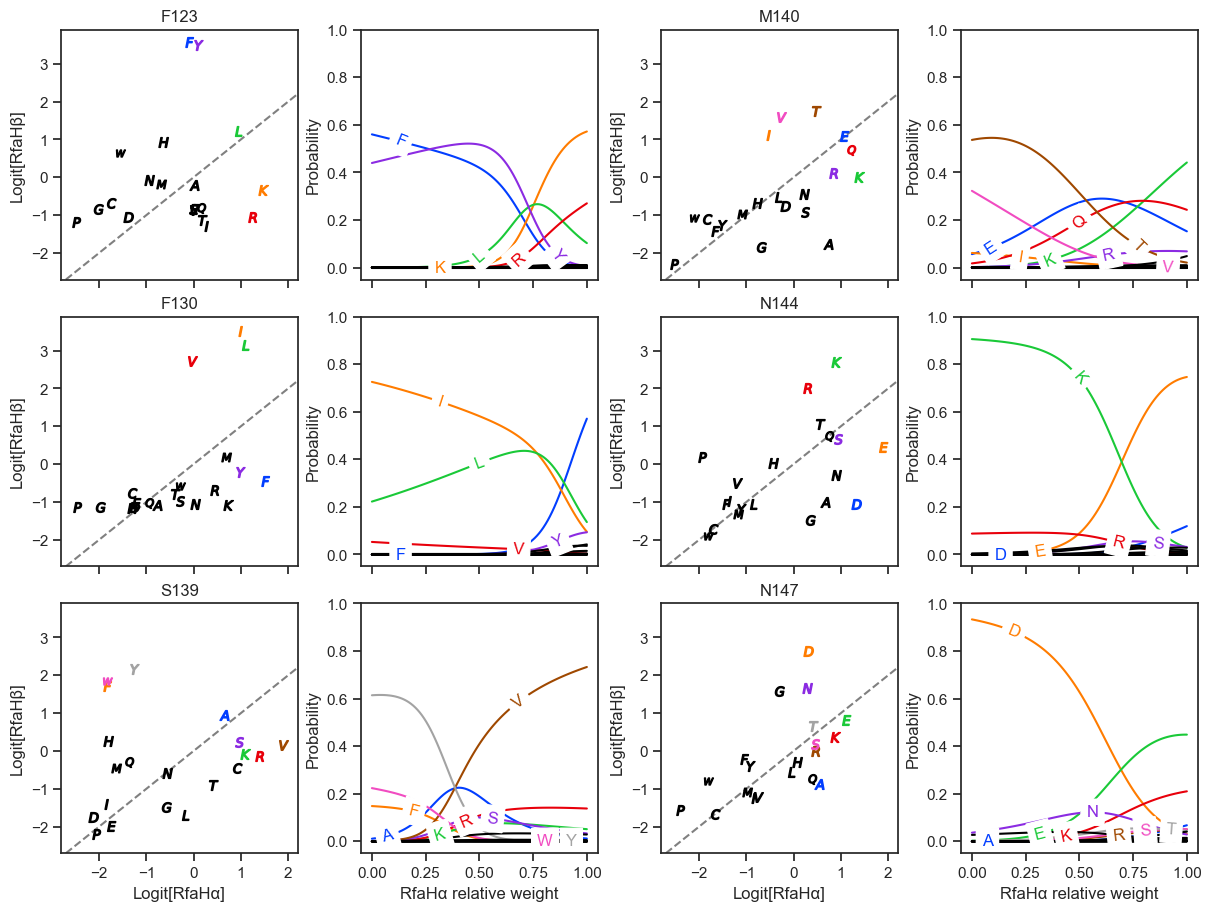

In [78]:
fig, axes= plt.subplots(3, 4, figsize= (12, 9), layout= 'constrained', sharex= 'col', sharey= 'col')

for res_idx, (resid, wt_aa) in enumerate(zip(resid_list, ['F', 'F', 'S', 'M', 'N', 'N'])):
    c_idx= 0
    for idx, (x_data, y_data, aa) in enumerate(zip(logits_df[f'{resid}_alpha'][:-1], logits_df[f'{resid}_beta'][:-1], pmpnn_alphabet[:-1])):
        if res_idx <= 2:
            ax_scatter= axes[res_idx, 0]
            ax_line= axes[res_idx, 1]
        else:
            ax_scatter= axes[res_idx-3, 2]
            ax_line= axes[res_idx-3, 3]

        y_line_data= ave_probs_weight_dict[resid][:, idx]
        if np.max(y_line_data) > 0.05:
            ax_scatter.scatter(
                x_data,
                y_data,
                marker= f'${aa}$',
                color= sns.color_palette('bright')[c_idx],
                s= 50
            )

            sns.lineplot(
                x= weight_list,
                y= y_line_data,
                color= sns.color_palette('bright')[c_idx],
                label= pmpnn_alphabet[idx],
                ax= ax_line
            )
            c_idx+= 1

        else:
            ax_scatter.scatter(
                x_data,
                y_data,
                marker= f'${aa}$',
                color= 'black',
                s= 50
            )
    labelLines(ax_line.get_lines())

    for idx in range(20):
        y_data= ave_probs_weight_dict[resid][:, idx]
        if np.max(y_data) <= 0.05:
            sns.lineplot(
                x= weight_list,
                y= y_data,
                label= pmpnn_alphabet[idx],
                ax= ax_line,
                color= 'black'
            )

    ax_scatter.set(
        xlabel= 'Logit[RfaHα]' if res_idx in [2, 5] else '',
        ylabel= 'Logit[RfaHβ]',
        xlim= [-2.8, 2.2],
        ylim= [-2.7, 3.9],
        title= f'{wt_aa}{resid}'
    )
    ax_line.get_legend().remove()
    ax_line.set(
        xlabel= 'RfaHα relative weight',
        ylabel= 'Probability',
        ylim= [-0.05, 1.0]
    )

    ax_scatter.axline(
        (-2, -2), (2, 2),
        color= 'gray',
        linestyle= 'dashed',
        zorder= 0
    )

plt.show()

#fig.savefig('./pmpnn_decode_weight_tuning.png', bbox_inches='tight', dpi= 600)

Comparison with NusG-like sequence database

In [79]:
full_RfaH_WT_seq= 'MQSWYLLYCKRGQLQRAQEHLERQAVNCLAPMITLEKIVRGKRTAVSEPLFPNYLFVEFDPEVIHTTTINATRGVSHFVRFGASPAIVPSAVIHQLSVYKPKDIVDPATPYPGDKVIITEGAFEGFQAIFTEPDGEARSMLLLNLINKEIKHSVKNTEFRKL'

In [96]:
# get the high confidence sequences
porter_database= pd.read_csv('data/41467_2022_31532_MOESM3_ESM.csv')
porter_reduced_database= porter_database[['Uniprot ID', 'CTD Seq', 'Overall Pred', 'Confidence 1', 'Confidence 2']]
porter_reduced_database_mask= (porter_reduced_database['Overall Pred'] != 'None') & (porter_reduced_database['Confidence 1'] == 'Good confidence') & (porter_reduced_database['Confidence 2'] == 'Good confidence')
porter_reduced_database= porter_reduced_database[porter_reduced_database_mask]

In [97]:
# get the full sequences from UniProtKB
porter_full_seqs = SeqIO.parse(open('data/idmapping_active_true_2023_12_17.fasta'),'fasta')

name_list= []
sequence_list= []
for record in porter_full_seqs:
    name, sequence = record.id, str(record.seq)
    id_str= name.split('|')[1]
    name_list.append(id_str)
    sequence_list.append(sequence)

porter_full_seqs_df= pd.DataFrame({'name': name_list, 'full_seq': sequence_list})
porter_combined_db= pd.merge(left= porter_reduced_database, right= porter_full_seqs_df, left_on= 'Uniprot ID', right_on= 'name')
porter_sampled_db= porter_combined_db.groupby("Overall Pred").sample(n=1000, random_state=1)

In [98]:
# get the aligned full sequences using clustal omega
porter_full_seqs_aligned= SeqIO.parse(open('data/porter_full_seqs_clustal_omega.fa'),'fasta')

name_list= []
sequence_list= []
for record in porter_full_seqs_aligned:
    name, sequence = record.id, str(record.seq)
    name_list.append(name)
    sequence_list.append(sequence)

porter_full_seqs_aligned_df= pd.DataFrame({'name': name_list, 'full_seq': sequence_list})

In [99]:
init_idx= 838
fin_idx= 905

ctd_seqs= [seq[init_idx:fin_idx] for seq in porter_full_seqs_aligned_df['full_seq']]
# ctd_seqs[964] corresponds to the ecRfaH
ecRfaH_no_gap_idx= [idx for idx, aa in enumerate(ctd_seqs[964]) if aa != '-']

ctd_seqs_ecRfaH_no_gap= ["".join(np.array(list(seq))[ecRfaH_no_gap_idx]).replace('-', '') for seq in ctd_seqs]
ctd_seqs_len= [len(seq) for seq in ctd_seqs_ecRfaH_no_gap]

porter_ctd_seqs_df= pd.DataFrame({'name': porter_full_seqs_aligned_df['name'], 'ctd_seq': ctd_seqs_ecRfaH_no_gap, 'ctd_seq_len': ctd_seqs_len})
porter_final_df= pd.merge(porter_ctd_seqs_df[porter_ctd_seqs_df['ctd_seq_len'] == 36], porter_sampled_db, left_on= 'name', right_on= 'Uniprot ID')[['ctd_seq', 'Overall Pred']]

In [100]:
porter_comparison_dict= {}

for ga_1_idx in [29, 31, 33, 35]:
    ga_2_idx= ga_1_idx + 7

    candidates= []
    methods= []

    new_candidates= list(df_GA_dict[ga_1_idx]['df'][-1]['candidate'].values)
    methods+= [f'GA_{ga_1_idx}']*len(new_candidates)
    candidates+= new_candidates

    new_candidates= list(df_GA_dict[ga_2_idx]['df'][-1]['candidate'].values)
    methods+= [f'GA_{ga_2_idx}']*len(new_candidates)
    candidates+= new_candidates

    new_candidates= list(df_AD_dict['df']['candidate'].values)
    methods+= ['AD']*len(new_candidates)
    candidates+= new_candidates
    
    candidates_df= pd.DataFrame({'candidate': candidates, 'method': methods})


    porter_FS= porter_final_df.loc[porter_final_df['Overall Pred'] == 'FS', 'ctd_seq']
    porter_NFS= porter_final_df.loc[porter_final_df['Overall Pred'] == 'NFS', 'ctd_seq']

    ga1_ctd_max_blosum= []
    for ga_ctd_seq in candidates_df.loc[candidates_df['method'] == f'GA_{ga_1_idx}', 'candidate']:
        blosum_dist_FS= np.quantile([aligner.align(ga_ctd_seq, database_seq).score/len(ga_ctd_seq) for database_seq in porter_FS], 0.95)
        blosum_dist_NFS= np.quantile([aligner.align(ga_ctd_seq, database_seq).score/len(ga_ctd_seq) for database_seq in porter_NFS], 0.95)
        ga1_ctd_max_blosum.append([blosum_dist_FS, blosum_dist_NFS])
    ga1_ctd_max_blosum= np.array(ga1_ctd_max_blosum)

    ga2_ctd_max_blosum= []
    for ga_ctd_seq in candidates_df.loc[candidates_df['method'] == f'GA_{ga_2_idx}', 'candidate']:
        blosum_dist_FS= np.quantile([aligner.align(ga_ctd_seq, database_seq).score/len(ga_ctd_seq) for database_seq in porter_FS], 0.95)
        blosum_dist_NFS= np.quantile([aligner.align(ga_ctd_seq, database_seq).score/len(ga_ctd_seq) for database_seq in porter_NFS], 0.95)
        ga2_ctd_max_blosum.append([blosum_dist_FS, blosum_dist_NFS])
    ga2_ctd_max_blosum= np.array(ga2_ctd_max_blosum)

    ad_ctd_max_blosum= []
    for ad_ctd_seq in candidates_df.loc[candidates_df['method'] == 'AD', 'candidate']:
        blosum_dist_FS= np.quantile([aligner.align(ad_ctd_seq, database_seq).score/len(ad_ctd_seq) for database_seq in porter_FS], 0.95)
        blosum_dist_NFS= np.quantile([aligner.align(ad_ctd_seq, database_seq).score/len(ad_ctd_seq) for database_seq in porter_NFS], 0.95)
        ad_ctd_max_blosum.append([blosum_dist_FS, blosum_dist_NFS])
    ad_ctd_max_blosum= np.array(ad_ctd_max_blosum)


    ga1_ctd_df= pd.DataFrame({'max(BLOSUM[FS])': ga1_ctd_max_blosum[:, 0], 'max(BLOSUM[NFS])': ga1_ctd_max_blosum[:, 1]})
    ga2_ctd_df= pd.DataFrame({'max(BLOSUM[FS])': ga2_ctd_max_blosum[:, 0], 'max(BLOSUM[NFS])': ga2_ctd_max_blosum[:, 1]})
    ad_ctd_df= pd.DataFrame({'max(BLOSUM[FS])': ad_ctd_max_blosum[:, 0], 'max(BLOSUM[NFS])': ad_ctd_max_blosum[:, 1]})

    ga1_ctd_df['type']= 'ga_1'
    ga2_ctd_df['type']= 'ga_2'
    ad_ctd_df['type']= 'ad'
    combined_ctd_df= pd.concat([ga1_ctd_df, ga2_ctd_df, ad_ctd_df], ignore_index= True)
    porter_comparison_dict[ga_1_idx]= combined_ctd_df

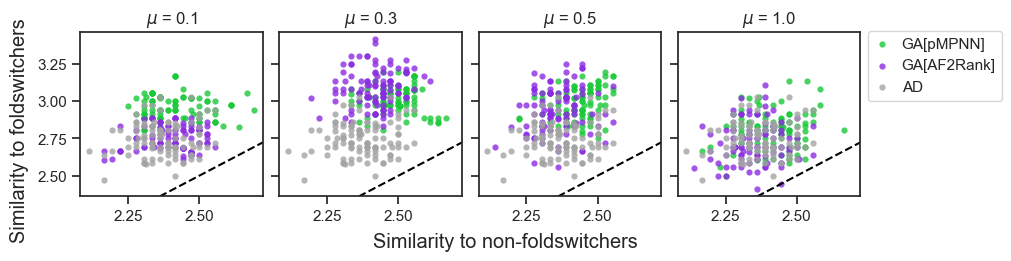

In [88]:
fig, axes= plt.subplots(1, 4, figsize= (10, 2.5), layout= 'constrained', sharex= True, sharey= True)

alpha= 0.8
s= 20

mu_list= [0.1, 0.3, 0.5, 1.0]

for idx, combined_ctd_df in enumerate(porter_comparison_dict.values()):
    sns.scatterplot(combined_ctd_df[combined_ctd_df['type'] == 'ga_1'], y= 'max(BLOSUM[FS])', x= 'max(BLOSUM[NFS])', ax= axes[idx], label= 'GA[pMPNN]', color= bright_colors[2], alpha= alpha, s= s, linewidth= 0)
    sns.scatterplot(combined_ctd_df[combined_ctd_df['type'] == 'ga_2'], y= 'max(BLOSUM[FS])', x= 'max(BLOSUM[NFS])', ax= axes[idx], label= 'GA[AF2Rank]', color= bright_colors[4], alpha= alpha, s= s, linewidth= 0)
    sns.scatterplot(combined_ctd_df[combined_ctd_df['type'] == 'ad'], y= 'max(BLOSUM[FS])', x= 'max(BLOSUM[NFS])', ax= axes[idx], label= 'AD', color= bright_colors[-3], alpha= alpha, s= s, linewidth= 0)

    axes[idx].axline((2.6,2.6), slope= 1, linestyle= '--', color= 'black')

    axes[idx].get_legend().remove()

    axes[idx].set(
        xlabel= '',
        ylabel= '',
        title= r'$\mu$ = ' + str(mu_list[idx]),
    )

legend_handles, _= axes[-1].get_legend_handles_labels()
axes[-1].legend(
    legend_handles, ['GA[pMPNN]', 'GA[AF2Rank]', 'AD'],
    bbox_to_anchor= (1, 1.05), loc= 'upper left',
    ncol= 1, columnspacing= 0.3, handlelength= 1
)

fig.supxlabel('Similarity to non-foldswitchers')
fig.supylabel('Similarity to foldswitchers')

plt.show()

#fig.savefig('./RfaH_porter_comparison.svg', bbox_inches='tight', dpi= 600)